<a href="https://colab.research.google.com/github/kaori-kanno/heart_recon/blob/main/recon_test_parteI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Usar GPU T4, si se requiere de hacer algo muy pesado, el A100

In [ ]:
# from google.colab import userdata
# token = userdata.get('cosas-tabita')

# !git clone 'https://{token}@github.com/kaori-kanno/NF-cMRI-tabita.git'
# %cd NF-cMRI-tabita/

In [ ]:
# !pip install -e . # instala como librería y e permite editar

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
# import inrmri

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive') # directorio de todas las carpetas
os.chdir("/content/drive/MyDrive/joint_recon/Pig_2")
!ls

Mounted at /content/drive
diffusion_directions.txt  kspace_real.mat   results_out3.pkl
image_imag.mat		  NF-cMRI-tabita    training_results_100k.pkl
image_real.mat		  results_out1.pkl  training_results_lr.pkl
kspace_imag.mat		  results_out2.pkl


In [ ]:
# ir = loadmat('Pig_2/image_real.mat')['image_real']
# im = loadmat('Pig_2/image_imag.mat')['image_imag']

ir_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_real.mat')
im_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_imag.mat')

In [ ]:
real = ir_data['image_real']
imag = im_data['image_imag']

In [ ]:
# kr = loadmat('Pig_2/kspace_real.mat')['kspace_real']
# ki = loadmat('Pig_2/kspace_imag.mat')['kspace_imag']

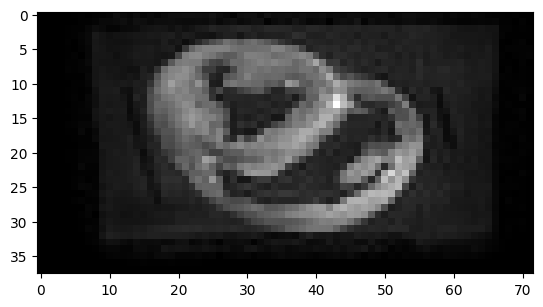

In [ ]:
image = real + 1j*imag # combinamos la parte real e imaginaria para formar la imagen completa
image = image/np.max(np.abs(image)) # se normaliza la imagen por el valor máximo

plt.imshow(np.abs(image[:,:,24,4,1]), cmap='gray') # seleccionamos el corte 24, y ciertas direcciones de difusión

In [ ]:
print(image.shape) # (x, y, z, valores_b, direcciones)

(38, 72, 49, 5, 457)


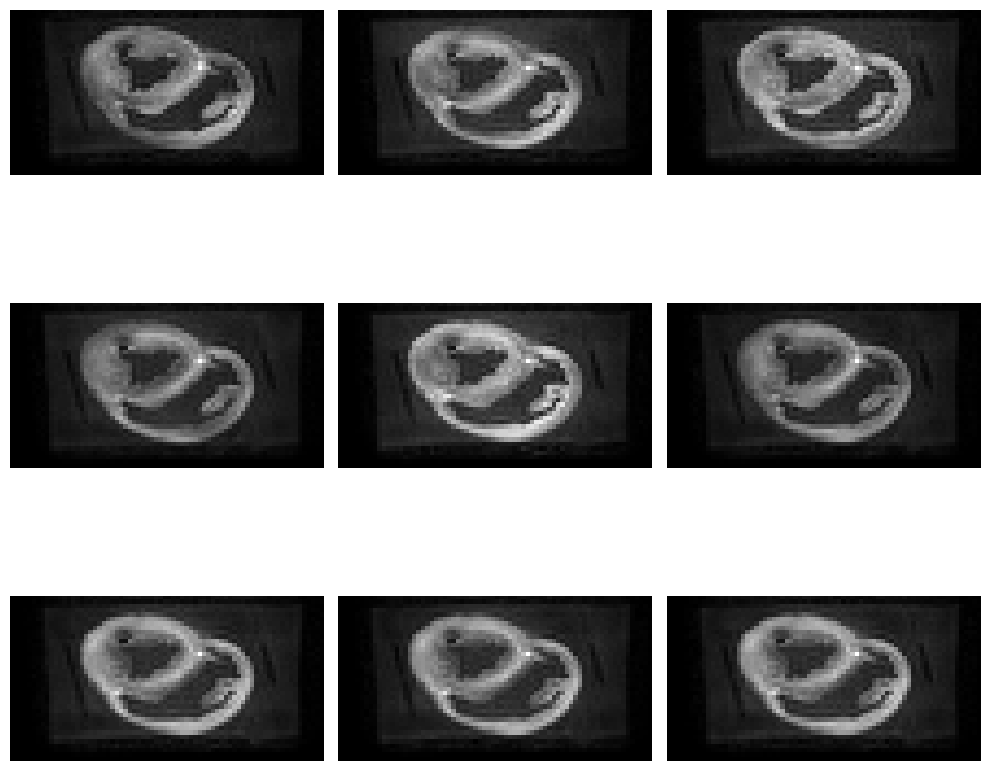

In [ ]:
plt.figure(figsize=(10,10))

for i in range(1, 10):
    plt.subplot(3,3,i)
    plt.imshow(np.abs(image[:,:,24,4,i]), cmap='gray') # cambiamos la última dirección i de difusión

    plt.axis('off')

plt.tight_layout()

In [ ]:
# recortamos un slice de todas las imágenes en el plano XY
slice = image[:,:,24,4,:]
slice = np.transpose(slice, (2,0,1))
# slice.shape

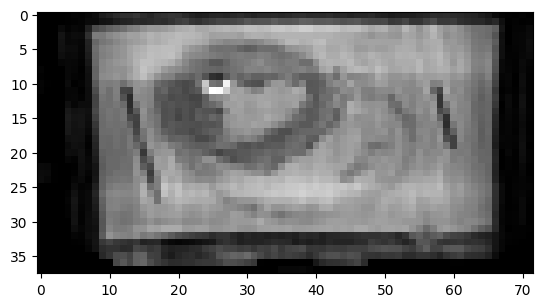

In [ ]:
M0 = image[:,:,24,0,0].copy() # imagen con b = 0 en corte 24
M0mask = np.abs(M0) > 0

plt.imshow(np.abs(M0), cmap='gray')

In [ ]:
np.abs(M0).min(), np.abs(M0).max() # valores de grises mínimos y máximos en M0

(np.float32(0.0), np.float32(0.86845744))

In [ ]:
# aplicamos Fourier en las imágenes

k_space = np.fft.fft2(slice)
k_space.shape

(457, 38, 72)

In [ ]:
n_masks = 6 # se crean máscaras en el espacio k para simular un muestreo de las imágenes
masks = []
max_lines = 11 # máximo de líneas que conservaremos en cada máscara.
bandwith = 3 # bandas a conservar al centro y a los extremos (información muy relevante en la imagen)
for i in range(n_masks):
    mask = np.zeros(k_space.shape[1:]).astype(bool) # creamos la máscara
    mask[np.arange(i,k_space.shape[1],6)] = 1 # en la máscara creada, marca como 1 (o True) cada 6 pasos, partiendo en i.


    # se conservan la banda superior e inferior como 1 o True:
    mask[-bandwith:] = 1
    mask[:bandwith] = 1

    if mask[:,0].sum() > max_lines: # si se excede el número de líneas permitidas
        idxs = np.where(mask[:,0]>0)[0] # se obtienen los índices de las filas
        order = np.argsort(np.abs(idxs - mask.shape[0]//2))
        idx = idxs[order][:(mask[:,0].sum() - max_lines)] # se ordenan las filas
        print(idx, mask[idxs[0],0])
        mask[idx,:] = 0 # se hacen 0 o False las líneas más alejadas del centro.

    masks.append(mask)
    print(mask[:,0].sum()) # imprimimos la suma de los valores que están en la fila 0 (deberían sumar max_lines)





38
38
38
38
38
38


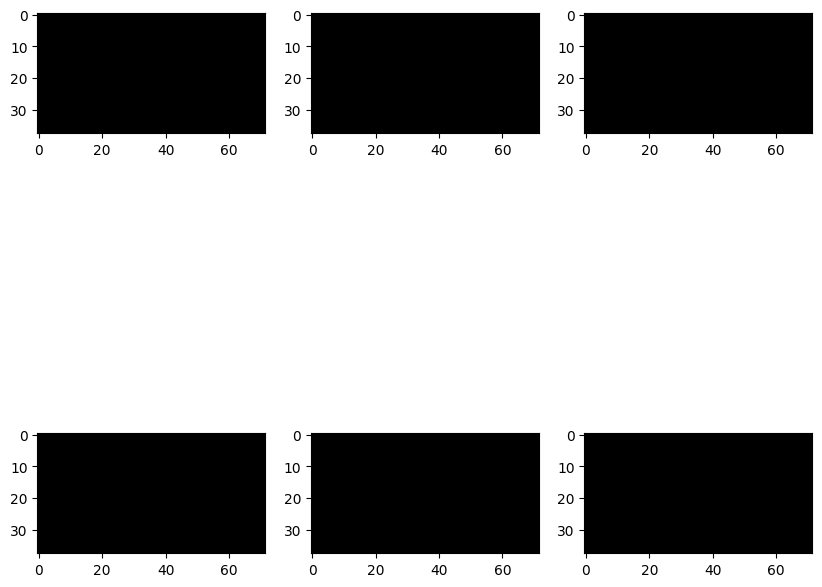

In [ ]:
# ploteamos las máscaras

plt.figure(figsize=(10,10))

for i, mask in enumerate(masks):
    plt.subplot(2,3,i+1)
    plt.imshow(np.fft.fftshift(mask), cmap='gray')

plt.show()

In [ ]:
k_space.shape[1]/mask[:,0].sum() # cantidad de imágenes / cantidad de filas

np.float64(1.0)

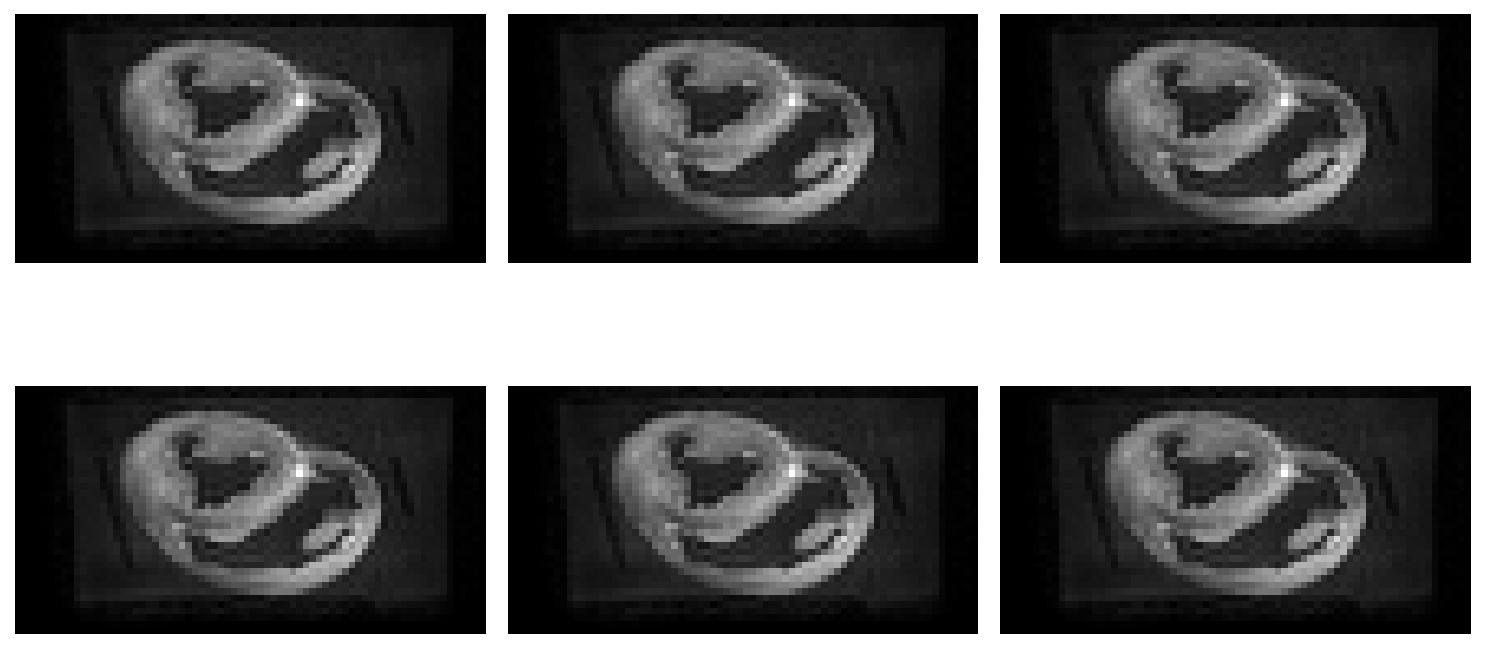

In [ ]:
plt.figure(figsize=(10,6), dpi = 150)

for i, mask in enumerate(masks):
    plt.subplot(2,3,i+1) # cuadrícula para los plots
    under_k_space = np.zeros(k_space.shape[1:], dtype=np.complex128)
    under_k_space[mask] = k_space[1][mask] # Se aplica mask sobre  k_space y se seleccionan solo las frecuencias de k_space[1] marcadas

    under_i = np.fft.ifft2(under_k_space) # Se realiza la transformada inversa de Fourier 2D (ifft2) sobre under_k_space

    plt.imshow(np.abs(under_i), cmap='gray') # se muestra la imagen reconstruída submuestreada.
    plt.axis('off')

plt.tight_layout()


## neural network

In [ ]:
import os

os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"

import jax.numpy as np
from jax import random, grad, jit, vmap
import jax
from jax.scipy.optimize import minimize
import numpy as onp
from jax.experimental.ode import odeint
from jax.example_libraries import optimizers
from functools import partial
from matplotlib import pyplot as plt
from jax.nn import relu
key = random.PRNGKey(0)

In [ ]:
def init_params(layers, key):
  Ws = [] # lista de matrices de pesos
  bs = [] # lista de vectores de sesgos
  for i in range(len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1])) # mediante glorot se definen los pesos
    key, subkey = random.split(key) # mantiene aleatoriedad controlada, mediante jax se asignan los pesos random
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(np.zeros(layers[i + 1])) # se crean los pesos en 0
  return (Ws, bs)

@jit
def forward_pass(H, params):
  """
  Esta es un MLP
  """
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = np.matmul(H, Ws[i]) + bs[i] # multiplicación de los pesos + bias
    H = np.tanh(H) # función de activación no lineal aplicada en la red
  Y = np.matmul(H, Ws[-1]) + bs[-1] # capa final sin función de activación
  return Y

def init_params_icnn(layers, key):
  Wz = [] # pesos aplicados a Z (capas intermedias)
  Wy = [] # pesos aplicados a Y (input original)
  bs = [] # bias para cada capa oculta

  std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
  key, subkey = random.split(key)
  Wy.append(random.normal(subkey, (layers[0], layers[1]))*std_glorot)

  for i in range(1,len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Wz.append(-3 + random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot) #Wz recibe pesos inicializados con ruido negativo (-3 + random...) para garantizar valores pequeños
    Wy.append(random.normal(subkey, (layers[0], layers[i + 1]))*std_glorot) # se conecta la capa de entrada, 0, con las capas ocultas
    bs.append(np.zeros(layers[i + 1]))
  return (Wz, Wy, bs)

@jit
def icnn_forwardpass(Y, params): # se recorren hacia adelante las capas
  """
  Esta es un ICNN
  """
  Wz, Wy, bs = params
  N_layers = len(Wy)
  Z = relu(np.matmul(Y, Wy[0]) + bs[0])  # esta es la capa de entrada Y
  for i in range(1, N_layers - 1): # aquí se recorren las capas intermedias
    Z = np.matmul(Z, np.exp(Wz[i-1])) + np.matmul(Y, Wy[i]) + bs[i]
    Z = relu(Z) # se da una función de activación
  Z = np.matmul(Z, np.exp(Wz[-1])) + np.matmul(Y, Wy[-1]) + bs[-1]  # última capa, sin activación no lineal
  return Z


@jit
def ff_forwardpass_B(X, params, B):
  """
  Aplicar Fourier a la data de entrada x.
  B es una matriz
  """
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X) # calcula el producto punto entre cada fila de X y B, B @ X.T
  # estos son los ángulos de los features
  gamma = np.concatenate((np.sin(angles), np.cos(angles)), axis = 1) # Fourier Feature Mapping, un truco para mapear tus datos a un espacio más rico.
  return forward_pass(gamma, params)  #  se pasa gamma por el MLP forward_pass

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)  # extrae los parámetros
    g = grad(loss)(params, X_batch, Y_batch)  # calcula el gradiente de la función de pérdida respecto a los parámetros
    return opt_update(i, g, opt_state) # actualiza los parámetros con un tamaño adecuado

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    """
    Aquí entrenamos el modelo para varias iteraciones con batches de data X e Y que se crean aquí
    """
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        # idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False) # toma un batch aleatorio
        opt_state = step(loss, it, opt_state, X, Y) # actualiza los parámetros con step
       # opt_state = step(loss, it, opt_state, X, Y)
        if it % 100 == 0:  # cada 100 iteraciones:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y) # train_loss_value = loss(params, X[idx_batch], Y[idx_batch])
            train_loss.append(train_loss_value)  # mide la pérdida del batch
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return opt_state, train_loss, val_loss

def train_batch(loss, Xb, Yb, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    it = 0
    while it < nIter: # itera en los batches
        for X, Y in zip(Xb, Yb): # Xb, Yb son listas de batches
          opt_state = step(loss, it, opt_state, X, Y)
          it += 1
          if it % 100 == 0:
              params = get_params(opt_state)
              train_loss_value = loss(params, X, Y)
              train_loss.append(train_loss_value)
              to_print = "it %i, train loss = %e" % (it, train_loss_value)
              print(to_print)
    return get_params(opt_state), train_loss, val_loss

def create_batches(input, output, batch_size):
    """
    Divide los datos en mini-batches y los devuelve
    """
    # Ensure input and output have the same first dimension length
    assert input.shape[0] == output.shape[0], "Input and output must have the same number of samples"

    num_samples = input.shape[0]  # número de muestras totales

    # Shuffle indices
    shuffled_indices = random.permutation(jax.random.PRNGKey(0), num_samples) # Crea un orden aleatorio de los índices (0 a num_samples-1)
    input_shuffled = input[shuffled_indices]
    output_shuffled = output[shuffled_indices] # reordena las muestras del output

    # Split the data into batches
    # Devuelve listas con batches de X e Y, listas de tamaño num_batches.
    input_batches = np.array_split(input_shuffled, num_samples // batch_size)
    output_batches = np.array_split(output_shuffled, num_samples // batch_size)

    return input_batches, output_batches




In [ ]:
@jit
def cartesian_to_spherical(x):
    """
    Se toma un vector 3D y se convierte a esféricas
    """
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    theta = np.arccos(x[2] / r)  # polar angle
    phi = np.arctan2(x[1], x[0])    # azimuthal angle
    return r, theta, phi

In [ ]:
# cargamos las direcciones de gradiente de difusión, son 457

dirs = onp.genfromtxt('diffusion_directions.txt', delimiter=';')

R, Theta, Phi= vmap(cartesian_to_spherical)(dirs) # vmap opera sobre un batch o conjunto de datos la operación dada

As = np.cos(Theta) # proyección en z de las direcciones
Bs = np.cos(Phi) # proyección en el plano XY



Acabamos de procesar direcciones existentes, podemos ahora mapear direcciones ideales:

In [ ]:
import mpl_toolkits.mplot3d

num_pts = 24
b_value = 6500
indices = np.arange(0, num_pts, dtype=float) + 0.5  # entrega valores igualmente espaciados en el rango (0, num_pts)
# sumamos 0.5 para que no sean los puntos de los extremos o los polos de la esfera.

phi = np.arccos(1 - 2*indices/num_pts) # esfera de Fibonacci
theta = np.pi * (1 + 5**0.5) * indices # esfera de Fibonacci, espiral con proporción áurea

# convertimos de esféricas a cartesianas con r = 1
# fórmula de fibonachi para una esfera donde los puntos están equidistantes repartidos.
x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)


# solo necesitamos mapear en una semi-esfera por simetría:
x_half = x[np.where(z >=0)]
y_half = y[np.where(z >=0)]
z_half = z[np.where(z >=0)]
b_value = np.repeat(b_value,x_half.shape[0])  # añadimos b al arreglo



directions = np.array([x_half,z_half,y_half]).transpose() # vector de dirección en 3d, (x, z, y)

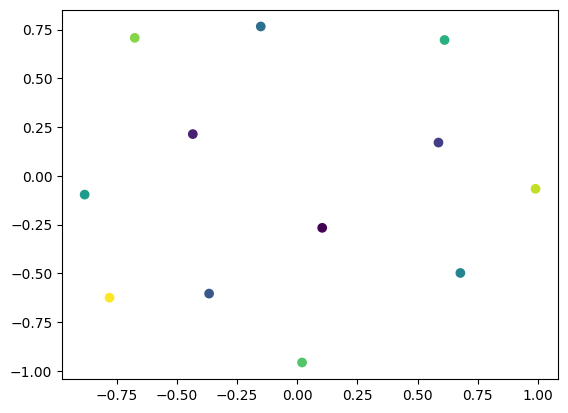

In [ ]:
plt.scatter(x_half, y_half, c = np.arange(x_half.shape[0]))

Array([0.99878776, 0.99778694, 0.9992423 , 0.9993435 , 0.99963474,
       0.99878   , 0.99890304, 0.9988388 , 0.999093  , 0.9991267 ,
       0.9997292 , 0.99772215], dtype=float32)

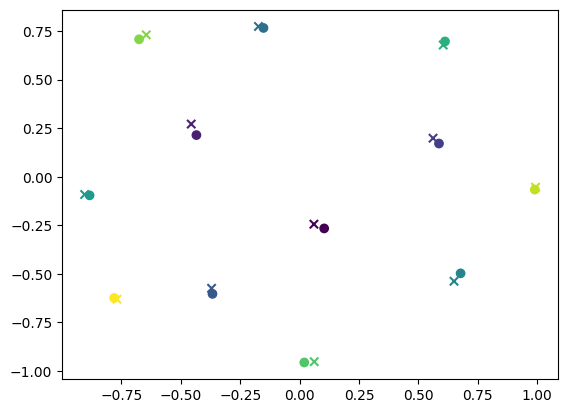

In [ ]:
# calculamos el producto punto entre cada dirección dir creada de direction con las otras direcciones dirs del scaner
ort = vmap(lambda dir, dirs: np.dot(dir,dirs), in_axes=(None, 0))(directions, dirs)


selected_dirs = np.argmax(ort, axis = 0) # el de mayor producto punto será la dirección más cercana
selected_dirs_vec = dirs[selected_dirs] # guardamos esas direcciones

plt.scatter(x_half, y_half, c = np.arange(x_half.shape[0]))
plt.scatter(selected_dirs_vec[:,0], selected_dirs_vec[:,2], c = np.arange(x_half.shape[0]), marker = 'x')
np.max(ort, axis = 0)

In [ ]:
# coordenadas del sistema:
Nx = k_space.shape[1] # tamaño de la transformada de fourier en x
Ny = k_space.shape[2] # tamaño de la transformada de fourier en y
x = np.arange(Nx)/(Nx - 1)*2 - 1 # normaliza las coordenadas Nx a valores entre -1 y 1
y = np.arange(Ny)/(Nx - 1)*2 - 1 # [0 a Ny-1]/(Ny-1) = [0 - 1]

X, Y = np.meshgrid(x, y, indexing = 'ij') # X, Y = np.meshgrid(x, y)
Xall = np.c_[X.flatten(), Y.flatten()] # aplana y concatena X con Y

# creamos las máscaras
masks = np.array(masks)
masks_rep = np.concatenate((masks, masks), axis = 0)  # se le agregan máscaras # masks_rep = np.concatenate((masks, masks[:3]), axis = 0)
input = []
output = []

for i,dir_idx in enumerate(selected_dirs): # son 9 puntos en selected_dirs
    input.append(np.c_[Xall, np.ones(Xall.shape[0])*As[dir_idx], np.ones(Xall.shape[0])*Bs[dir_idx]]) # (xs, ys, cos(th), cos(phi))
input = np.array(input)
# recordar que Xall.shape = (Nx * Ny, 2) y As[dir_idx] sería la dirección de un vector de selected_dirs



print(k_space[selected_dirs].shape) # (num_puntos 12, x, y)
output = k_space[selected_dirs][masks_rep] # se le aplica la máscara a las direcciones seleccionados.
print(input.shape, output.shape) # (num_puntos 12, num_puntos_visibles Nx*Ny, 4 (x, y, cos, cos)) y un valor


(12, 38, 72)
(12, 2736, 4) (32832,)


best params for 9 directions:

```
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*0.1

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)

layers = [2*N_ff+2, 256, 256,256, 2]

params = init_params(layers, key)


#lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.99)
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(params)
params, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 200000) #100000
```


### first training

In [ ]:
masks = np.array(masks)

@jit
def forward_model(X, params):
    I = ff_forwardpass(X, params) # pasa por la función de más abajo que lleva a ff_forwwardpass_mixed
    I = I[:,0] + 1j*I[:,1] # se convierte la imagen a una compleja
    I = I.reshape((Nx, Ny)) # I = I.reshape(mask.shape) # se reconstruye la imagen
    k_space = np.fft.fft2(I) # transforma a k-space
    return k_space

n_pix = k_space.shape[1]*k_space.shape[2]

@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


@jit
def ff_forwardpass_mixed(X, params, B):
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X[:,:2]) # 2pi * (proyecciones)
  input = np.concatenate((np.sin(angles), np.cos(angles), X[:,2:]), axis = 1)
  return forward_pass(input, params)

sigma = 0.15
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)

layers = [2*N_ff+2, 256, 256,256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
params = init_params(layers, key)



In [ ]:
def psnr(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  print(k_spaces.shape)
  mse = np.mean(np.abs((k_spaces - Y))**2/(n_pix))
  max_value = np.max(np.abs(Y))
  return 20 * np.log10(max_value / (np.sqrt(mse)))

In [ ]:
def loss_orig(params, input, Y):
  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  return np.mean(np.abs((k_spaces - Y))**2/(n_pix))

In [ ]:
#lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.99)
opt_init, opt_update, get_params = optimizers.adam(1e-3)  #  Adam con learning rate 1e-3
opt_state = opt_init(params)
# opt_state_mil, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 1000) # 1000

In [ ]:
# params_mil = get_params(opt_state_mil)
# loss(params_mil, input, output) #MSE

In [ ]:
# guardamos aquí los parámetros en drive para no tener que recorrer el código cada vez


import pickle
save_path='/content/drive/MyDrive/joint_recon'

# with open(f'{save_path}/params_mil.pkl', 'wb') as f:
#     pickle.dump(params_mil, f)

# with open(f'{save_path}/opt_state_mil.pkl', 'wb') as f:
#     pickle.dump(opt_state_mil, f)

In [ ]:
# cargamos el archivo ya creado a partir del código anterior

with open(f'{save_path}/params_mil.pkl', "rb") as f:
    params_mil = pickle.load(f)

with open(f'{save_path}/opt_state_mil.pkl', "rb") as f:
    opt_state_mil = pickle.load(f)

In [ ]:
# comprobamos que se guardara correctamente

loss(params_mil, input, output) #MSE

Array(0.00149069, dtype=float32)

In [ ]:
print(psnr(params_mil, input, k_space[selected_dirs]))
print(loss_orig(params_mil, input, k_space[selected_dirs]))

(12, 38, 72)
68.76032
0.0014906892


In [ ]:
# opt_state_10mil, train_loss, val_loss = train(loss,input, output, opt_state_mil, key, nIter= 9000) #10.000
# params_10mil = get_params(opt_state_10mil)
# loss(params_10mil, input, output) #MSE

In [ ]:
# with open(f'{save_path}/params_10mil.pkl', 'wb') as f:
#     pickle.dump(params_10mil, f)

# with open(f'{save_path}/opt_state_10mil.pkl', 'wb') as f:
#     pickle.dump(opt_state_10mil, f)

In [ ]:
with open(f'{save_path}/params_10mil.pkl', "rb") as f:
    params_10mil = pickle.load(f)

with open(f'{save_path}/opt_state_10mil.pkl', "rb") as f:
    opt_state_10mil = pickle.load(f)

In [ ]:
loss(params_10mil, input, output) #MSE

Array(0.00097507, dtype=float32)

In [ ]:
print(psnr(params_10mil, input, k_space[selected_dirs]))
print(loss_orig(params_10mil, input, k_space[selected_dirs]))

(12, 38, 72)
70.60382
0.0009750725


In [ ]:
# comprobamos que usar opt_state1 funciona de manera similar a haber partido de esa iteración

# params1, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 10000) #10.000
# loss(params1, input, output) #MSE

In [ ]:
# opt_state_50mil, train_loss, val_loss = train(loss,input, output, opt_state_10mil, key, nIter= 40000) #50.000
# params_50mil = get_params(opt_state_50mil)
# loss(params_50mil, input, output) #MSE

In [ ]:
# with open(f'{save_path}/params_50mil.pkl', 'wb') as f:
#     pickle.dump(params_50mil, f)

# with open(f'{save_path}/opt_state_50mil.pkl', 'wb') as f:
#     pickle.dump(opt_state_50mil, f)

In [ ]:
with open(f'{save_path}/params_50mil.pkl', "rb") as f:
    params_50mil = pickle.load(f)

with open(f'{save_path}/opt_state_50mil.pkl', "rb") as f:
    opt_state_50mil = pickle.load(f)

In [ ]:
loss(params_50mil, input, output) #MSE

Array(0.00206275, dtype=float32)

In [ ]:
psnr(params_50mil, input, k_space[selected_dirs])

(12, 38, 72)


Array(67.34973, dtype=float32)

In [ ]:
# opt_state_100mil, train_loss, val_loss = train(loss,input, output, opt_state_50mil, key, nIter= 60000) #100.000
# params_100mil = get_params(opt_state_100mil)
# loss(params_100mil, input, output) #MSE

In [ ]:
# with open(f'{save_path}/params_100mil.pkl', 'wb') as f:
#     pickle.dump(params_100mil, f)

# with open(f'{save_path}/opt_state_100mil.pkl', 'wb') as f:
#     pickle.dump(opt_state_100mil, f)

In [ ]:
with open(f'{save_path}/params_100mil.pkl', "rb") as f:
    params_100mil = pickle.load(f)

with open(f'{save_path}/opt_state_100mil.pkl', "rb") as f:
    opt_state_100mil = pickle.load(f)

In [ ]:
loss(params_100mil, input, output) #MSE

Array(0.00018555, dtype=float32)

In [ ]:
psnr(params_100mil, input, k_space[selected_dirs])

(12, 38, 72)


Array(77.80951, dtype=float32)

In [ ]:
print(loss_orig(params_100mil, input, k_space[selected_dirs]))

0.00018555325


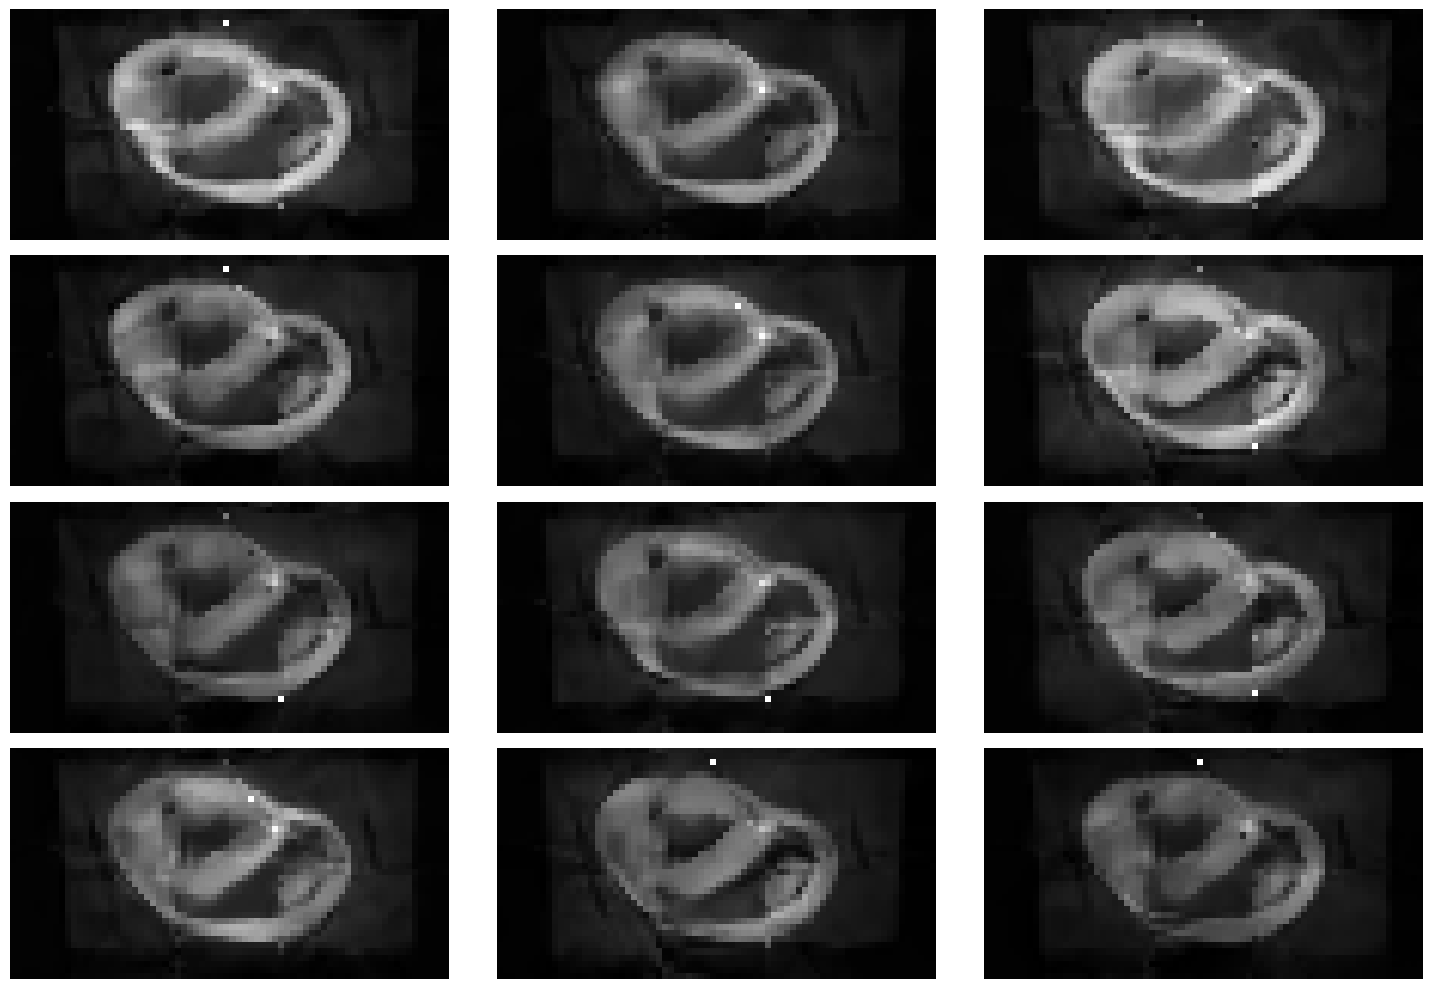

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_100mil)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# opt_state_200mil, train_loss, val_loss = train(loss,input, output, opt_state_100mil, key, nIter= 100000) #200.000
# params_200mil = get_params(opt_state_200mil)
# loss(params_200mil, input, output) #MSE

In [ ]:
# with open(f'{save_path}/params_200mil.pkl', 'wb') as f:
#     pickle.dump(params_200mil, f)

# with open(f'{save_path}/opt_state_200mil.pkl', 'wb') as f:
#     pickle.dump(opt_state_200mil, f)

In [ ]:
with open(f'{save_path}/params_200mil.pkl', "rb") as f:
    params_200mil = pickle.load(f)

with open(f'{save_path}/opt_state_200mil.pkl', "rb") as f:
    opt_state_200mil = pickle.load(f)

In [ ]:
loss(params_200mil, input, output) #MSE

Array(0.00014725, dtype=float32)

In [ ]:
psnr(params_200mil, input, k_space[selected_dirs])

(12, 38, 72)


Array(78.813644, dtype=float32)

In [ ]:
print(loss_orig(params_200mil, input, k_space[selected_dirs]))

0.00014724968


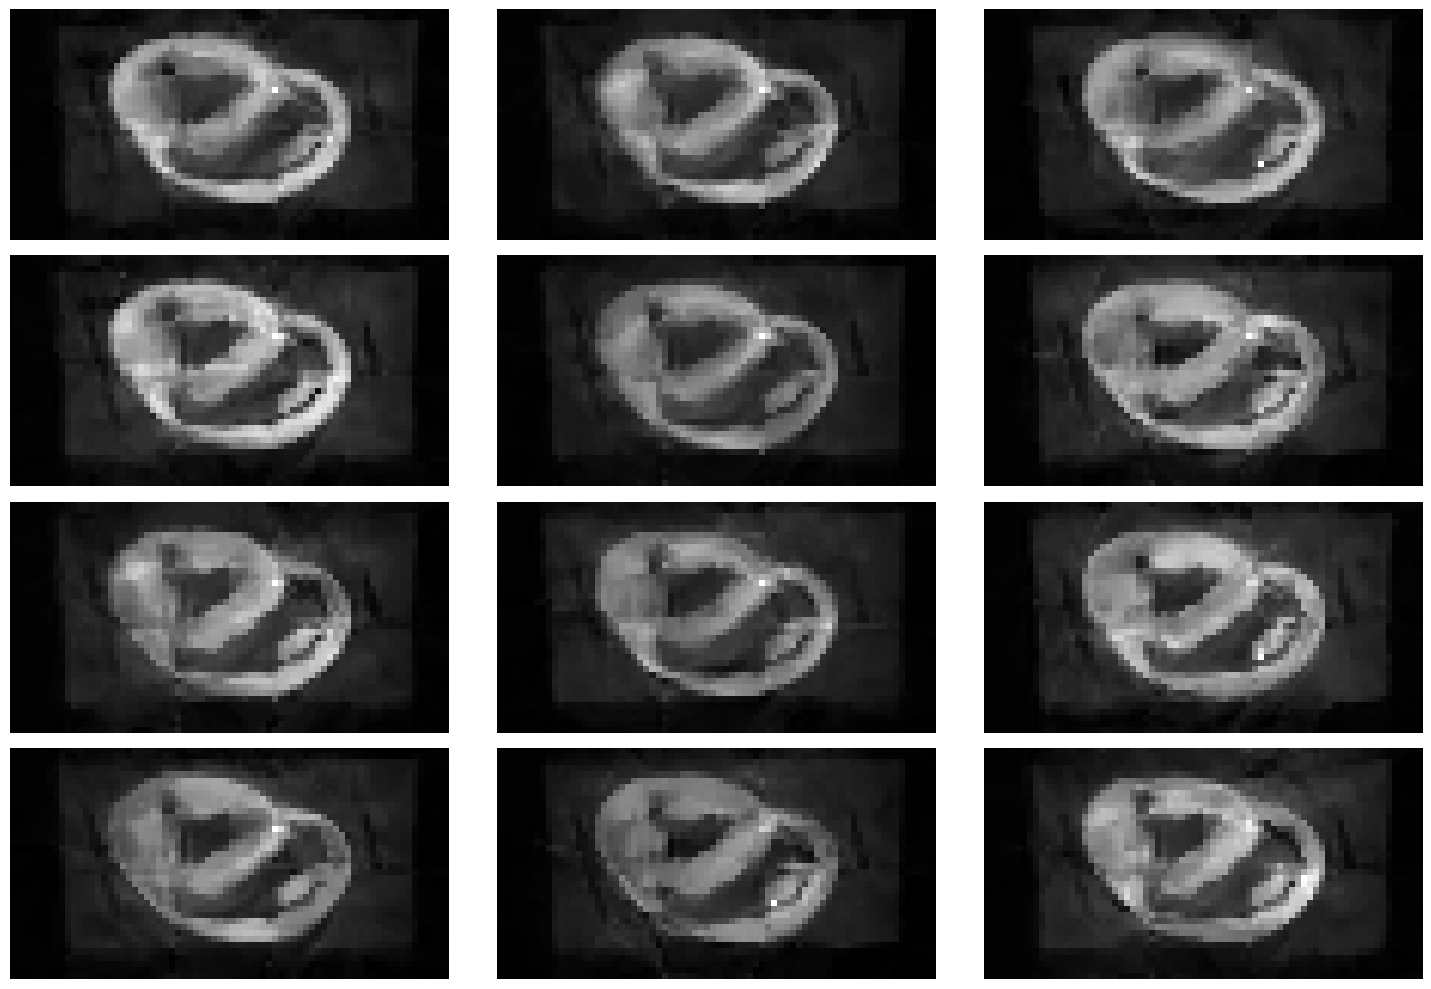

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_200mil)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

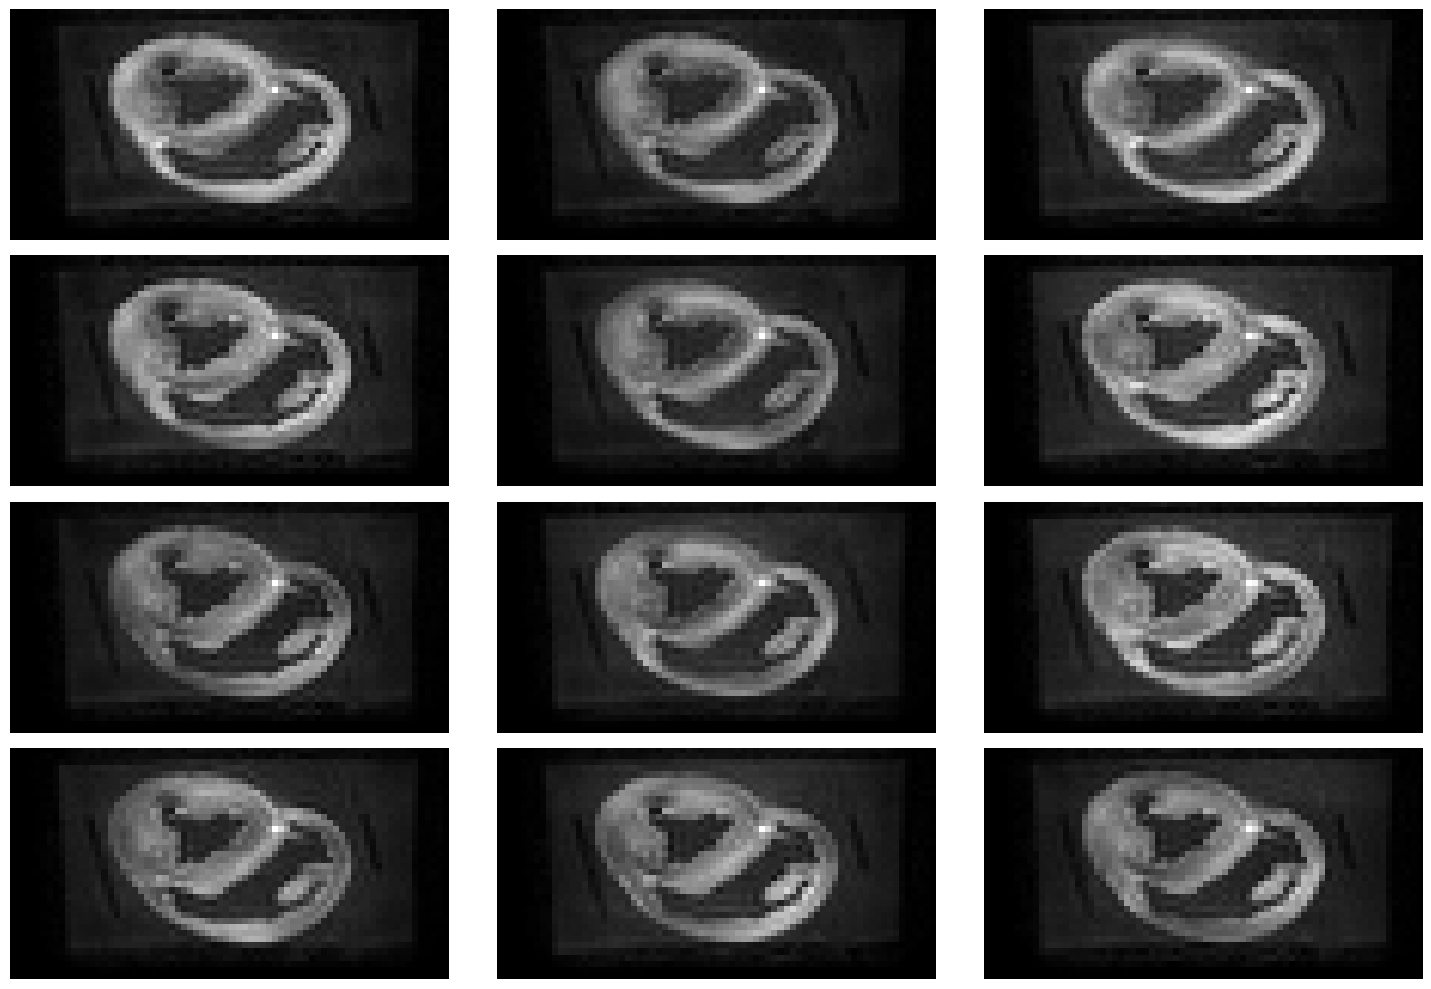

In [ ]:
plt.figure(figsize=(15,10))

for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)

    plt.imshow(np.abs(slice[idx]).reshape((Nx, Ny)), cmap='gray') # imagen slice del dataset original de tamaño Nx, Ny
    plt.axis('off')

plt.tight_layout()

#### Second try first training:

Probamos aquí cambiando el número de neuronas de cada capa

In [ ]:
# layers = [2*N_ff+2, 512, 512, 512, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 512 neuronas y 2 neuronas de salida para parte real e im
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adam(1e-3)  #  Adam con learning rate 1e-3
# opt_state = opt_init(params)
# opt_state1, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000)


In [ ]:
# with open(f'{save_path}/params_1.pkl', 'wb') as f:
#     pickle.dump(params1, f)

# with open(f'{save_path}/opt_state_1.pkl', 'wb') as f:
#     pickle.dump(opt_state1, f)

In [ ]:
with open(f'{save_path}/params_1.pkl', "rb") as f:
    params1 = pickle.load(f)

with open(f'{save_path}/opt_state_1.pkl', "rb") as f:
    opt_state1 = pickle.load(f)

In [ ]:
params1 = get_params(opt_state1)
loss(params1, input, output)

Array(0.0001576, dtype=float32)

In [ ]:
psnr(params1, input, k_space[selected_dirs])

(12, 38, 72)


Array(78.51871, dtype=float32)

In [ ]:
print(loss_orig(params_mil, input, k_space[selected_dirs]))

0.0014906892


Probamos ahora cambiar el número de capas en sí

In [ ]:
# layers = [2*N_ff+2, 256, 256, 256, 256, 256, 2] # define las capas de la red; capa de entrada, 5 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adam(1e-3)  #  Adam con learning rate 1e-3
# opt_state = opt_init(params)
# opt_state2, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 2*10-4 demora más en ejecutar, no va tan lento como el anterior

In [ ]:
# with open(f'{save_path}/params_2.pkl', 'wb') as f:
#     pickle.dump(params2, f)

# with open(f'{save_path}/opt_state_2.pkl', 'wb') as f:
#     pickle.dump(opt_state2, f)

In [ ]:
with open(f'{save_path}/params_2.pkl', "rb") as f:
    params2 = pickle.load(f)

with open(f'{save_path}/opt_state_2.pkl', "rb") as f:
    opt_state2 = pickle.load(f)

In [ ]:
params2 = get_params(opt_state2)
print(loss(params2, input, output))
print(psnr(params2, input, k_space[selected_dirs]))
print(loss_orig(params2, input, k_space[selected_dirs]))

9.762474e-05
(12, 38, 72)
80.598595
9.762474e-05


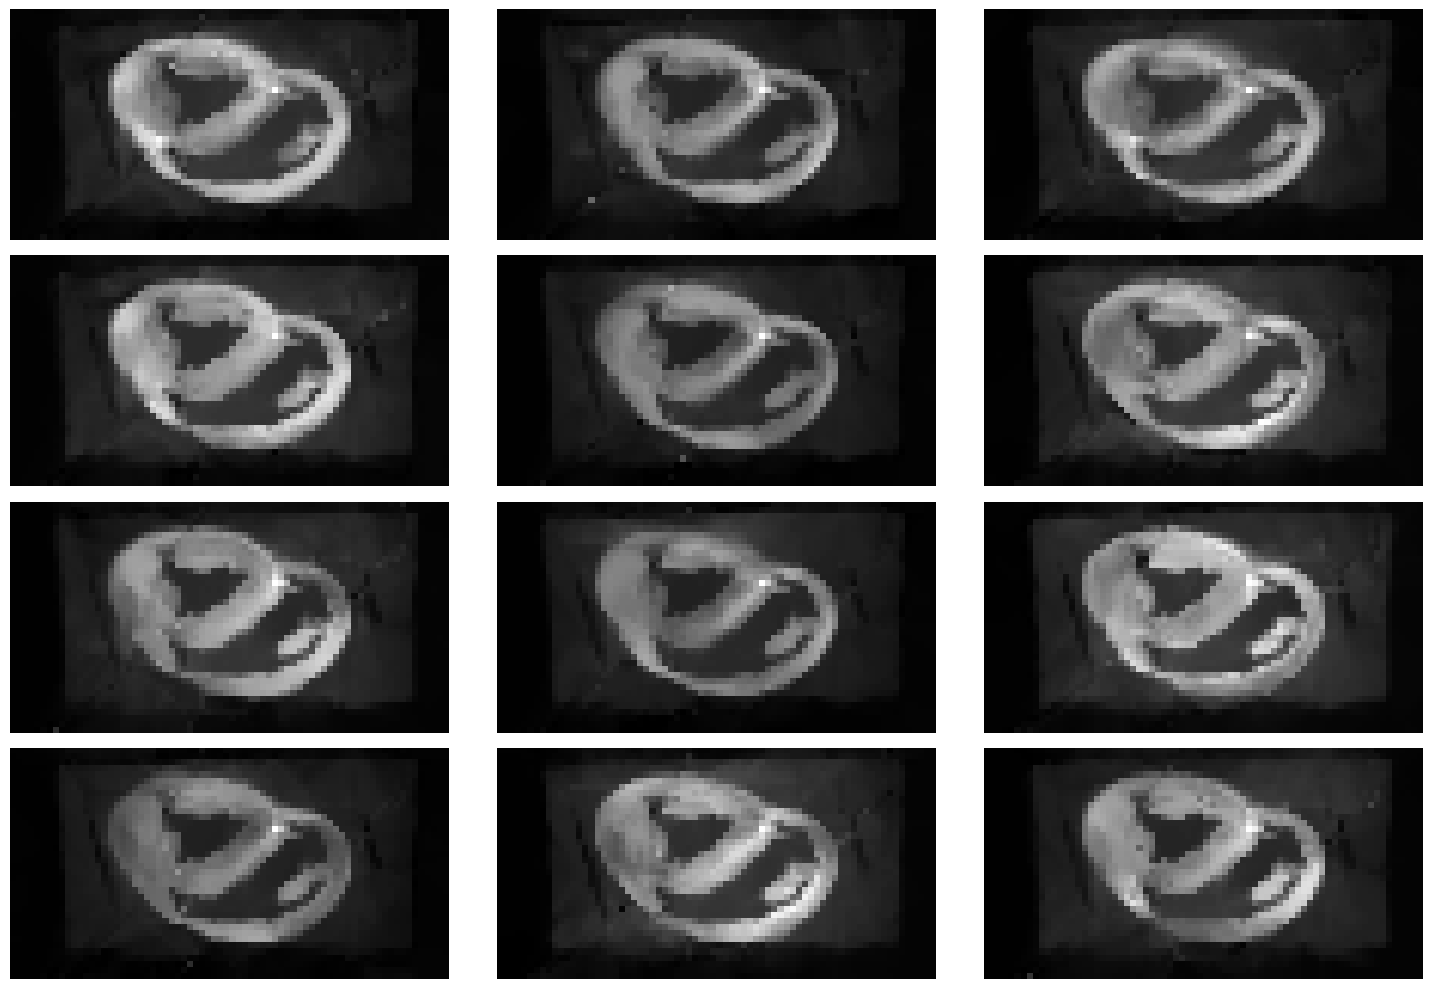

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params2)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

Cambiemos ahora el learning rate a ver qué pasa

In [ ]:
# layers = [2*N_ff+2, 256, 256, 256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 512 neuronas y 2 neuronas de salida para parte real e im
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adam(1e-4)  #  Adam con learning rate 1e-4
# opt_state = opt_init(params)
# opt_state_lr4, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000)

In [ ]:
# with open(f'{save_path}/params_lr4.pkl', 'wb') as f:
#     pickle.dump(params_lr4, f)

# with open(f'{save_path}/opt_state_lr4.pkl', 'wb') as f:
#     pickle.dump(opt_state_lr4, f)

In [ ]:
with open(f'{save_path}/params_lr4.pkl', "rb") as f:
    params_lr4 = pickle.load(f)

with open(f'{save_path}/opt_state_lr4.pkl', "rb") as f:
    opt_state_lr4 = pickle.load(f)

In [ ]:
params_lr4 = get_params(opt_state_lr4)
print(loss(params_lr4, input, output))
print(psnr(params_lr4, input, k_space[selected_dirs]))
print(loss_orig(params_lr4, input, k_space[selected_dirs]))

0.00034230005
(12, 38, 72)
75.15013
0.00034230005


In [ ]:
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adam(1e-2)  #  Adam con learning rate 1e-2
# opt_state = opt_init(params)
# opt_state_lr2, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000)

In [ ]:
# with open(f'{save_path}/params_lr2.pkl', 'wb') as f:
#     pickle.dump(params_lr2, f)

# with open(f'{save_path}/opt_state_lr2.pkl', 'wb') as f:
#     pickle.dump(opt_state_lr2, f)

In [ ]:
with open(f'{save_path}/params_lr2.pkl', "rb") as f:
    params_lr2 = pickle.load(f)

with open(f'{save_path}/opt_state_lr2.pkl', "rb") as f:
    opt_state_lr2 = pickle.load(f)

In [ ]:
params_lr2 = get_params(opt_state_lr2)
print(loss(params_lr2, input, output)) # mejora, tratar con más puntos
print(psnr(params_lr2, input, k_space[selected_dirs]))
print(loss_orig(params_lr2, input, k_space[selected_dirs]))

0.00034230005
(12, 38, 72)
75.15013
0.00034230005


In [ ]:
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adam(5e-3)  #  Adam con learning rate 5e-3
# opt_state = opt_init(params)
# opt_state_lr5, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000)

In [ ]:
# with open(f'{save_path}/params_lr5.pkl', 'wb') as f:
#     pickle.dump(params_lr5, f)

# with open(f'{save_path}/opt_state_lr5.pkl', 'wb') as f:
#     pickle.dump(opt_state_lr5, f)

In [ ]:
with open(f'{save_path}/params_lr5.pkl', "rb") as f:
    params_lr5 = pickle.load(f)

with open(f'{save_path}/opt_state_lr5.pkl', "rb") as f:
    opt_state_lr5 = pickle.load(f)

In [ ]:
params_lr5 = get_params(opt_state_lr5)
print(loss(params_lr5, input, output)) # mejora, tratar con más puntos
print(psnr(params_lr5, input, k_space[selected_dirs]))
print(loss_orig(params_lr5, input, k_space[selected_dirs]))

0.00034230005
(12, 38, 72)
75.15013
0.00034230005


Otro optimizador

In [ ]:
# layers = [2*N_ff+2, 256, 256, 256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 512 neuronas y 2 neuronas de salida para parte real e im
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adamax(1e-3)  #  Adam max
# opt_state = opt_init(params)
# opt_state_adamax, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 5*10-4

In [ ]:
# with open(f'{save_path}/params_adamax.pkl', 'wb') as f:
#     pickle.dump(params_adamax, f)

# with open(f'{save_path}/opt_state_adamax.pkl', 'wb') as f:
#     pickle.dump(opt_state_adamax, f)

In [ ]:
with open(f'{save_path}/params_adamax.pkl', "rb") as f:
    params_adamax = pickle.load(f)

with open(f'{save_path}/opt_state_adamax.pkl', "rb") as f:
    opt_state_adamax = pickle.load(f)

In [ ]:
params_adamax = get_params(opt_state_adamax)
print(loss(params_adamax, input, output)) # mejora, tratar con más puntos
print(psnr(params_adamax, input, k_space[selected_dirs]))
print(loss_orig(params_adamax, input, k_space[selected_dirs]))

0.00034230005
(12, 38, 72)
75.15013
0.00034230005


In [ ]:
# layers = [2*N_ff+2, 256, 256, 256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.rmsprop(1e-3)  #  otro
# opt_state = opt_init(params)
# opt_state_rms, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 2*10-4

In [ ]:
# with open(f'{save_path}/params_rms.pkl', 'wb') as f:
#     pickle.dump(params_rms, f)

# with open(f'{save_path}/opt_state_rms.pkl', 'wb') as f:
#     pickle.dump(opt_state_rms, f)

In [ ]:
with open(f'{save_path}/params_rms.pkl', "rb") as f:
    params_rms = pickle.load(f)

with open(f'{save_path}/opt_state_rms.pkl', "rb") as f:
    opt_state_rms = pickle.load(f)

In [ ]:
print(loss(params_rms, input, output))
print(psnr(params_rms, input, k_space[selected_dirs]))
print(loss_orig(params_mil, input, k_space[selected_dirs]))

0.00027204945
(12, 38, 72)
76.14772
0.0014906892


In [ ]:
# layers = [2*N_ff+2, 256, 256, 256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adagrad(1e-3)  #  AdaGrad
# opt_state = opt_init(params)
# opt_state_ada, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 5*10-4

In [ ]:
# with open(f'{save_path}/params_ada.pkl', 'wb') as f:
#     pickle.dump(params_ada, f)

# with open(f'{save_path}/opt_state_ada.pkl', 'wb') as f:
#     pickle.dump(opt_state_ada, f)

In [ ]:
with open(f'{save_path}/params_ada.pkl', "rb") as f:
    params_ada = pickle.load(f)

with open(f'{save_path}/opt_state_ada.pkl', "rb") as f:
    opt_state_ada = pickle.load(f)

In [ ]:
params_ada = get_params(opt_state_ada)
print(loss(params_ada, input, output)) # mejora, tratar con más puntos
print(psnr(params_ada, input, k_space[selected_dirs]))
print(loss_orig(params_ada, input, k_space[selected_dirs]))

0.000341682
(12, 38, 72)
75.157974
0.000341682


Otra función de pérdida

In [ ]:
# @jit
# def loss(params, input, Y):
#     k_spaces = vmap(partial(forward_model, params=params))(input)
#     return np.mean(np.abs(np.squeeze(k_spaces[masks_rep]) - Y) / n_pix) #MAE

# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adam(1e-3)  #  Adam con learning rate 1e-3
# opt_state = opt_init(params)
# opt_state_mae, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 2*10-4

In [ ]:
# with open(f'{save_path}/params_mae.pkl', 'wb') as f:
#     pickle.dump(params_mae, f)

# with open(f'{save_path}/opt_state_mae.pkl', 'wb') as f:
#     pickle.dump(opt_state_mae, f)

In [ ]:
with open(f'{save_path}/params_mae.pkl', "rb") as f:
    params_mae = pickle.load(f)

with open(f'{save_path}/opt_state_mae.pkl', "rb") as f:
    opt_state_mae = pickle.load(f)

In [ ]:
params_mae = get_params(opt_state_mae)
print(loss(params_mae, input, output)) # mejora, tratar con más puntos
print(psnr(params_mae, input, k_space[selected_dirs]))
print(loss_orig(params_mae, input, k_space[selected_dirs]))

0.0003735731
(12, 38, 72)
74.77044
0.0003735731


In [ ]:
# plt.figure(figsize=(15,10))

# for i, inp in enumerate(input):
#     plt.subplot(4,3,i+1)
#     I = ff_forwardpass(inp, params_mae)
#     I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
#     plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
#     plt.axis('off')

# plt.tight_layout()

In [ ]:
# probamos con una combinación de funciones de pérdida

# layers = [2*N_ff+2, 256, 256, 256, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#     k_spaces = vmap(partial(forward_model, params=params))(input)
#     error = np.squeeze(k_spaces[masks_rep]) - Y
#     mae = np.mean(np.abs(error)) / n_pix
#     mse = np.mean(np.abs(error)**2) / n_pix
#     return 0.3 * mae + 0.7 * mse

# params = init_params(layers, key)

# opt_init, opt_update, get_params = optimizers.adam(1e-2)  #  Adam con learning rate 1e-3
# opt_state = opt_init(params)
# opt_state_msemae, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # 2*10-4

In [ ]:
# with open(f'{save_path}/params_msemae.pkl', 'wb') as f:
#     pickle.dump(params_msemae, f)

# with open(f'{save_path}/opt_state_msemae.pkl', 'wb') as f:
#     pickle.dump(opt_state_msemae, f)

In [ ]:
with open(f'{save_path}/params_msemae.pkl', "rb") as f:
    params_msemae = pickle.load(f)

with open(f'{save_path}/opt_state_msemae.pkl', "rb") as f:
    opt_state_msemae = pickle.load(f)

In [ ]:
params_msemae = get_params(opt_state_msemae)
print(loss(params_msemae, input, output))
print(psnr(params_msemae, input, k_space[selected_dirs]))
print(loss_orig(params_msemae, input, k_space[selected_dirs]))

0.00077848614
(12, 38, 72)
71.58168
0.00077848614


Combinación de posibles mejoras:

In [ ]:
# layers = [2*N_ff+2, 512, 512, 512, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#     k_spaces = vmap(partial(forward_model, params=params))(input)
#     return np.mean(np.abs(np.squeeze(k_spaces[masks_rep]) - Y) / n_pix) #MAE

# opt_init, opt_update, get_params = optimizers.adam(5e-3)  #  Adam con learning rate 5e-3
# opt_state = opt_init(params)
# opt_state_m, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 2*10-4

In [ ]:
# with open(f'{save_path}/params_m.pkl', 'wb') as f:
#     pickle.dump(params_m, f)

# with open(f'{save_path}/opt_state_m.pkl', 'wb') as f:
#     pickle.dump(opt_state_m, f)

In [ ]:
with open(f'{save_path}/params_m.pkl', "rb") as f:
    params_m = pickle.load(f)

with open(f'{save_path}/opt_state_m.pkl', "rb") as f:
    opt_state_m = pickle.load(f)

In [ ]:
params_m = get_params(opt_state_m)
print(loss(params_m, input, output)) # mejora, tratar con más puntos
print(psnr(params_m, input, k_space[selected_dirs]))
print(loss_orig(params_m, input, k_space[selected_dirs]))

0.0061972034
(12, 38, 72)
62.572243
0.0061972034


In [ ]:
# # cambiar solo learning rate por el otro bueno

# layers = [2*N_ff+2, 512, 512, 512, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#     k_spaces = vmap(partial(forward_model, params=params))(input)
#     return np.mean(np.abs(np.squeeze(k_spaces[masks_rep]) - Y) / n_pix) #MAE

# opt_init, opt_update, get_params = optimizers.adam(1e-2)  #  Adam con learning rate 5e-3
# opt_state = opt_init(params)
# opt_state_m2, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 5*10-4

In [ ]:
# with open(f'{save_path}/params_m2.pkl', 'wb') as f:
#     pickle.dump(params_m2, f)

# with open(f'{save_path}/opt_state_m2.pkl', 'wb') as f:
#     pickle.dump(opt_state_m2, f)

In [ ]:
with open(f'{save_path}/params_m2.pkl', "rb") as f:
    params_m2 = pickle.load(f)

with open(f'{save_path}/opt_state_m2.pkl', "rb") as f:
    opt_state_m2 = pickle.load(f)

In [ ]:
params_m2 = get_params(opt_state_m2)
print(loss(params_m2, input, output)) # mejora, tratar con más puntos
print(psnr(params_m2, input, k_space[selected_dirs]))
print(loss_orig(params_m2, input, k_space[selected_dirs]))

0.10954486
(12, 38, 72)
50.098274
0.10954486


In [ ]:
# # cambiar solo neuronas

# layers = [2*N_ff+2, 256, 256, 256, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#     k_spaces = vmap(partial(forward_model, params=params))(input)
#     return np.mean(np.abs(np.squeeze(k_spaces[masks_rep]) - Y) / n_pix) #MAE

# opt_init, opt_update, get_params = optimizers.adam(5e-3)  #  Adam con learning rate 5e-3
# opt_state = opt_init(params)
# opt_state_m3, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 5*10-4

In [ ]:
# with open(f'{save_path}/params_m3.pkl', 'wb') as f:
#     pickle.dump(params_m3, f)

# with open(f'{save_path}/opt_state_m3.pkl', 'wb') as f:
#     pickle.dump(opt_state_m3, f)

In [ ]:
with open(f'{save_path}/params_m3.pkl', "rb") as f:
    params_m3 = pickle.load(f)

with open(f'{save_path}/opt_state_m3.pkl', "rb") as f:
    opt_state_m3 = pickle.load(f)

In [ ]:
params_m3 = get_params(opt_state_m3)
print(loss(params_m3, input, output)) # mejora, tratar con más puntos
print(psnr(params_m3, input, k_space[selected_dirs]))
print(loss_orig(params_m3, input, k_space[selected_dirs]))

0.0029942875
(12, 38, 72)
65.73126
0.0029942875


In [ ]:
# # cambiar solo función loss
# layers = [2*N_ff+2, 512, 512, 512, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#   k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
#   return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


# opt_init, opt_update, get_params = optimizers.adam(5e-3)  #  Adam con learning rate 5e-3
# opt_state = opt_init(params)
# opt_state_m4, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 5*10-4

In [ ]:
# with open(f'{save_path}/params_m4.pkl', 'wb') as f:
#     pickle.dump(params_m4, f)

# with open(f'{save_path}/opt_state_m4.pkl', 'wb') as f:
#     pickle.dump(opt_state_m4, f)

In [ ]:
# with open(f'{save_path}/params_m4.pkl', "rb") as f:
#     params_m4 = pickle.load(f)

with open(f'{save_path}/opt_state_m4.pkl', "rb") as f:
    opt_state_m4 = pickle.load(f)

In [ ]:
params_m4 = get_params(opt_state_m4)
print(loss(params_m4, input, output)) # mejora, tratar con más puntos
print(psnr(params_m4, input, k_space[selected_dirs]))
print(loss_orig(params_m4, input, k_space[selected_dirs]))

0.00061088114
(12, 38, 72)
72.63463
0.00061088114


In [ ]:
# # cambiar solo neuronas

# layers = [2*N_ff+2, 256, 256, 256, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#     k_spaces = vmap(partial(forward_model, params=params))(input)
#     return np.mean(np.abs(np.squeeze(k_spaces[masks_rep]) - Y) / n_pix) #MAE

# opt_init, opt_update, get_params = optimizers.adam(5e-3)  #  Adam con learning rate 5e-3
# opt_state = opt_init(params)
# opt_state_m5, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000) # comparar con 2*10-4

In [ ]:
# with open(f'{save_path}/params_m5.pkl', 'wb') as f:
#     pickle.dump(params_m5, f)

# with open(f'{save_path}/opt_state_m5.pkl', 'wb') as f:
#     pickle.dump(opt_state_m5, f)

In [ ]:
with open(f'{save_path}/params_m5.pkl', "rb") as f:
    params_m5 = pickle.load(f)

with open(f'{save_path}/opt_state_m5.pkl', "rb") as f:
    opt_state_m5 = pickle.load(f)

In [ ]:
params_m5 = get_params(opt_state_m)
print(loss(params_m5, input, output))
print(psnr(params_m5, input, k_space[selected_dirs]))
print(loss_orig(params_m5, input, k_space[selected_dirs]))

0.0061972034
(12, 38, 72)
62.572243
0.0061972034


In [ ]:
from jax import tree_util

def l2_penalty(params):
    return sum([np.sum(p**2) for p in tree_util.tree_leaves(params)])

def l1_penalty(params):
    return sum([np.sum(np.abs(p)) for p in tree_util.tree_leaves(params)])



In [ ]:
# @jit
# def loss(params, input, Y):
#     lambda_l2=1e-4
#     k_spaces = vmap(partial(forward_model, params=params))(input)
#     mse = np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2 / n_pix)
#     reg = lambda_l2 * l2_penalty(params)
#     return mse + reg


# layers = [2*N_ff+2, 256, 256, 256, 2]
# params = init_params(layers, key)
# opt_state = opt_init(params)
# opt_state_l2, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000)


In [ ]:
# with open(f'{save_path}/params_l2.pkl', 'wb') as f:
#     pickle.dump(params_l2, f)

# with open(f'{save_path}/opt_state_l2.pkl', 'wb') as f:
#     pickle.dump(opt_state_l2, f)

In [ ]:
with open(f'{save_path}/params_l2.pkl', "rb") as f:
    params_l2 = pickle.load(f)

with open(f'{save_path}/opt_state_l2.pkl', "rb") as f:
    opt_state_l2 = pickle.load(f)

In [ ]:
params_l2 = get_params(opt_state_l2)
print(loss(params_l2, input, output)) # mejora, tratar con más puntos
print(psnr(params_l2, input, k_space[selected_dirs]))

0.003054519
(12, 38, 72)
65.64477


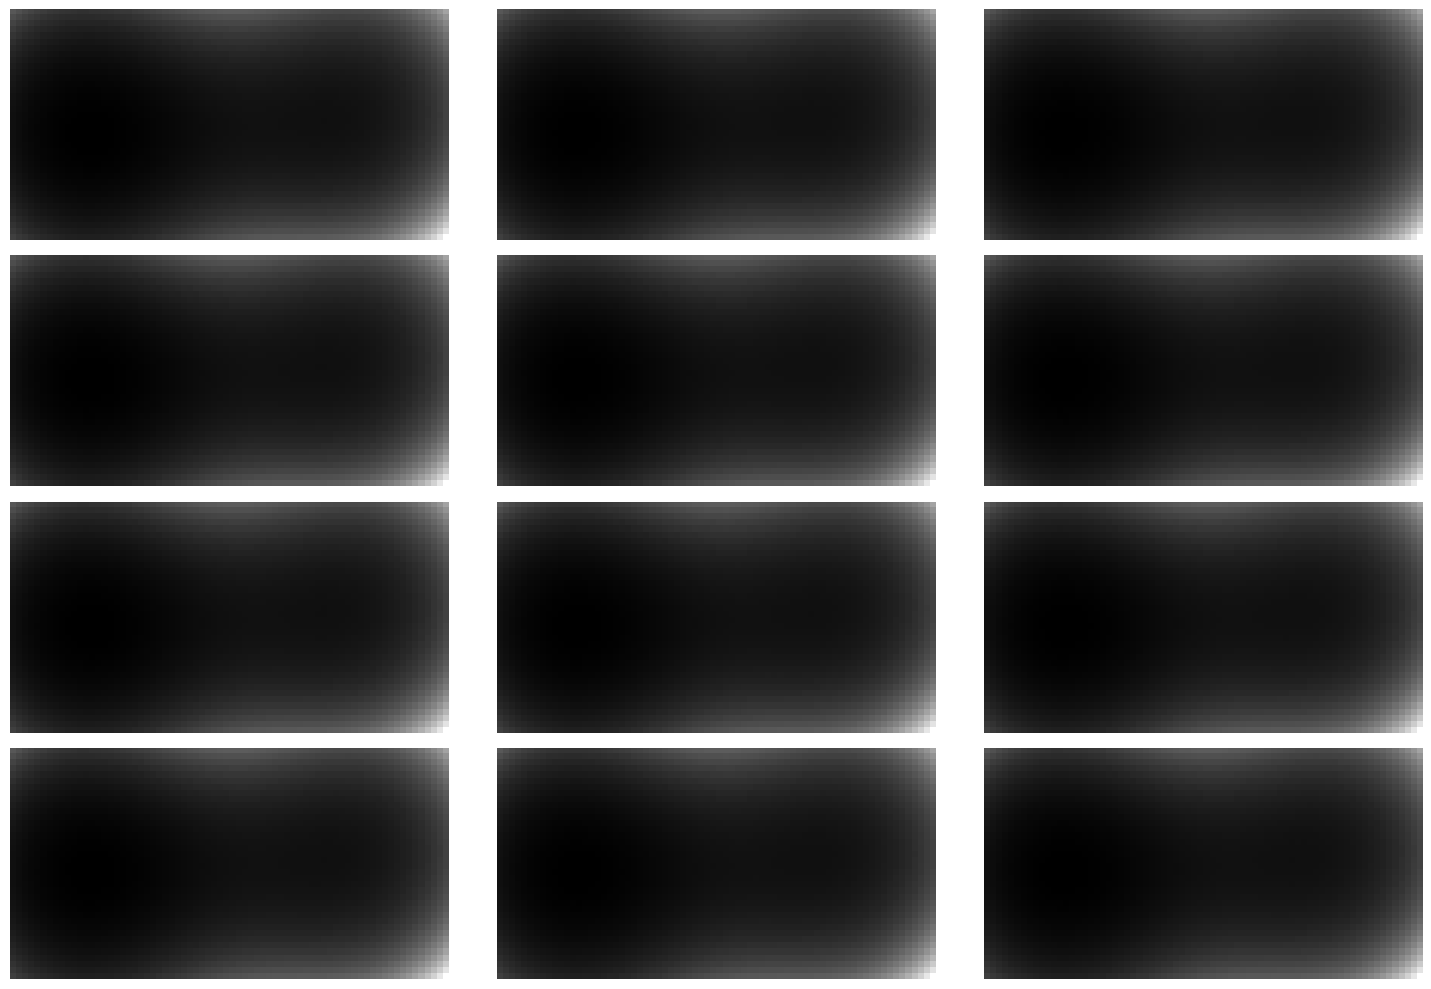

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_l2)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# @jit
# def loss(params, input, Y):
#     lambda_l1=1e-5
#     k_spaces = vmap(partial(forward_model, params = params))(input)
#     mse = np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2 / n_pix)
#     reg = lambda_l1 * l1_penalty(params)
#     return mse + reg

# # @jit
# # def loss(params, input, Y):
# #   k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
# #   return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix

# layers = [2*N_ff+2, 256, 256, 256, 2]
# params = init_params(layers, key)
# opt_state = opt_init(params)
# opt_state_l1, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000)

In [ ]:
# with open(f'{save_path}/params_l1.pkl', 'wb') as f:
#     pickle.dump(params_l1, f)

# with open(f'{save_path}/opt_state_l1.pkl', 'wb') as f:
#     pickle.dump(opt_state_l1, f)

In [ ]:
with open(f'{save_path}/params_l1.pkl', "rb") as f:
    params_l1 = pickle.load(f)

with open(f'{save_path}/opt_state_l1.pkl', "rb") as f:
    opt_state_l1 = pickle.load(f)

In [ ]:
params_l1 = get_params(opt_state_l1)
print(loss(params_l1, input, output)) # mejora, tratar con más puntos
print(psnr(params_l1, input, k_space[selected_dirs]))

0.0007869205
(12, 38, 72)
71.53489


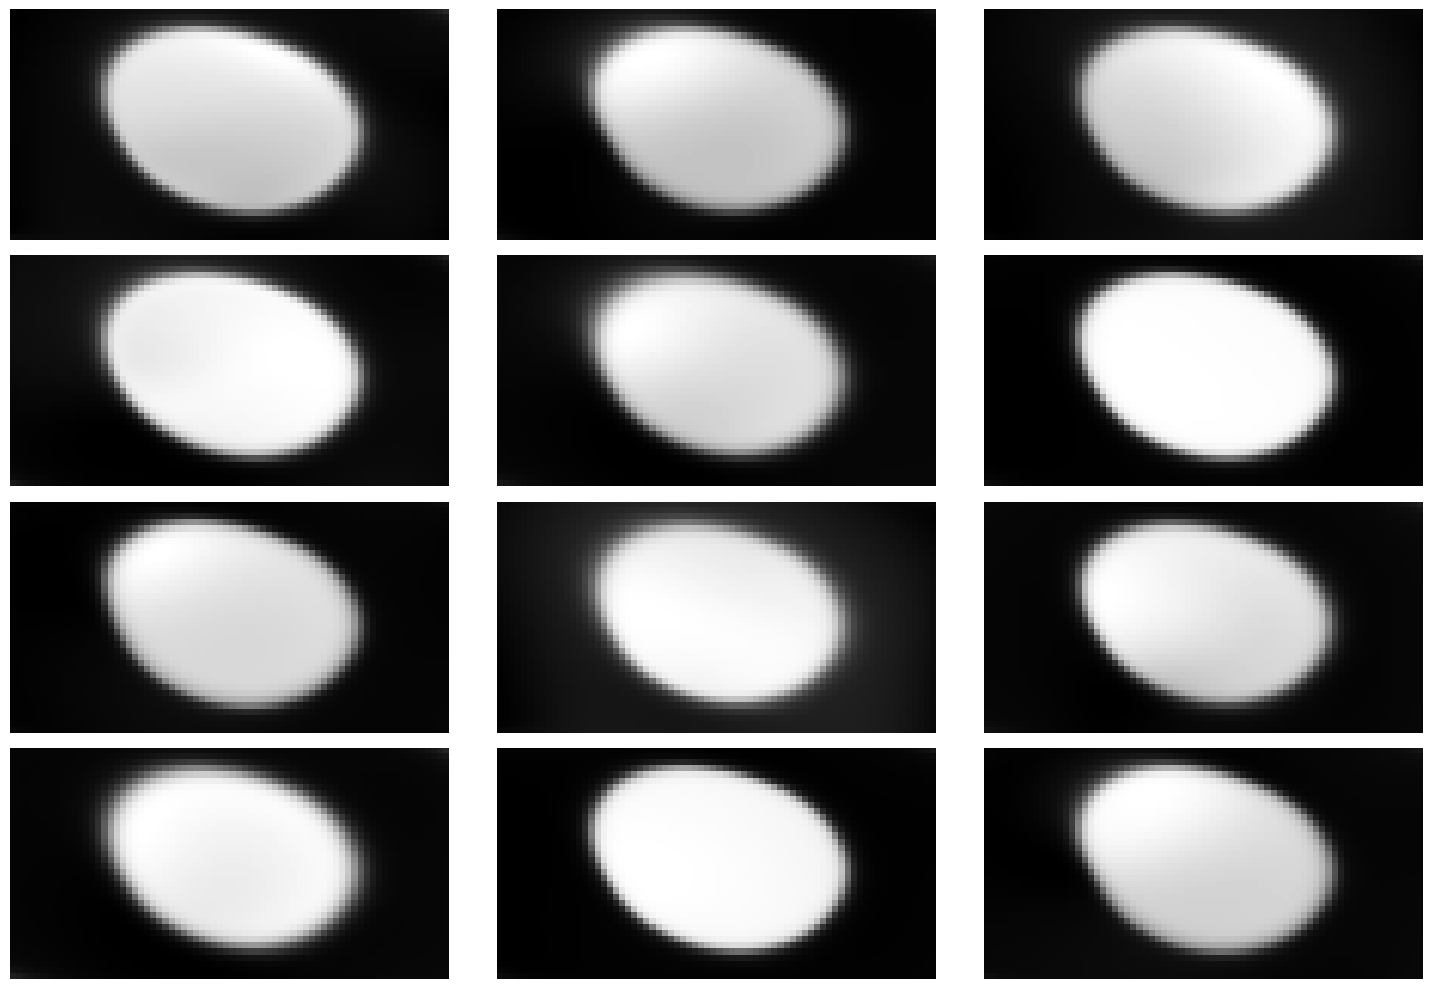

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_l1)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

Agregamos un decay en el learning rate

In [ ]:
# learning rate que baja

# layers = [2*N_ff+2, 256, 256, 256, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#   k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
#   return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix

# lr = optimizers.exponential_decay(5e-3, decay_steps=1000, decay_rate=0.99)
# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# opt_state_lr_exp, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 100000)

In [ ]:
# with open(f'{save_path}/params_lr_exp.pkl', 'wb') as f:
#     pickle.dump(params_lr_exp, f)

# with open(f'{save_path}/opt_state_lr_exp.pkl', 'wb') as f:
#     pickle.dump(opt_state_lr_exp, f)

In [ ]:
with open(f'{save_path}/params_lr_exp.pkl', "rb") as f:
    params_lr_exp = pickle.load(f)

with open(f'{save_path}/opt_state_lr_exp.pkl', "rb") as f:
    opt_state_lr_exp = pickle.load(f)

In [ ]:
params_lr_exp = get_params(opt_state_lr_exp)
print(loss(params_lr_exp, input, output)) # mejora, tratar con más puntos
print(psnr(params_lr_exp, input, k_space[selected_dirs]))
print(loss_orig(params_lr_exp, input, k_space[selected_dirs]))

0.00017098212
(12, 38, 72)
78.16469
0.00017098212


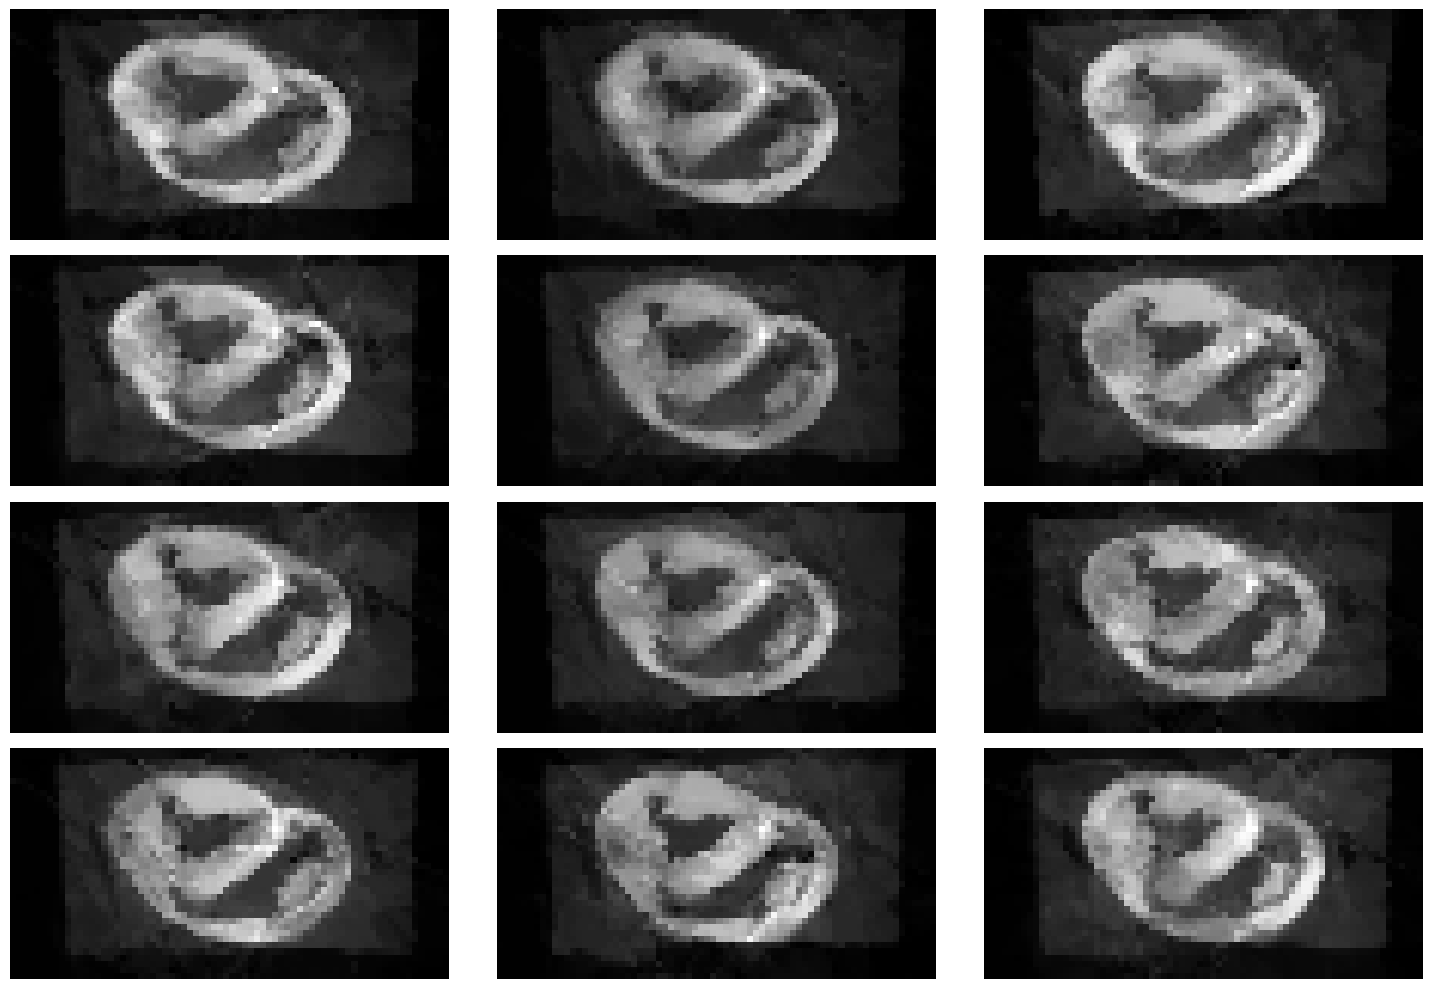

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_lr_exp)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# # learning rate que baja

# layers = [2*N_ff+2, 256, 256, 256, 2]
# params = init_params(layers, key)

# @jit
# def loss(params, input, Y):
#   k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
#   return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix

# lr = optimizers.exponential_decay(5e-3, decay_steps=1000, decay_rate=0.99)
# opt_init, opt_update, get_params = optimizers.adam(lr)
# opt_state = opt_init(params)
# opt_state_lr_exp200, train_loss, val_loss = train(loss,input, output, opt_state_lr_exp, key, nIter= 100000)

In [ ]:
# with open(f'{save_path}/params_lr_exp200.pkl', 'wb') as f:
#     pickle.dump(params_lr_exp200, f)

# with open(f'{save_path}/opt_state_lr_exp200.pkl', 'wb') as f:
#     pickle.dump(opt_state_lr_exp200, f)

In [ ]:
with open(f'{save_path}/params_lr_exp200.pkl', "rb") as f:
    params_lr_exp200 = pickle.load(f)

with open(f'{save_path}/opt_state_lr_exp200.pkl', "rb") as f:
    opt_state_lr_exp200 = pickle.load(f)

In [ ]:
params_lr_exp200 = get_params(opt_state_lr_exp)
print(loss(params_lr_exp200, input, output))
print(psnr(params_lr_exp200, input, k_space[selected_dirs]))
print(loss_orig(params_lr_exp200, input, k_space[selected_dirs]))

0.00017098212
(12, 38, 72)
78.16469
0.00017098212


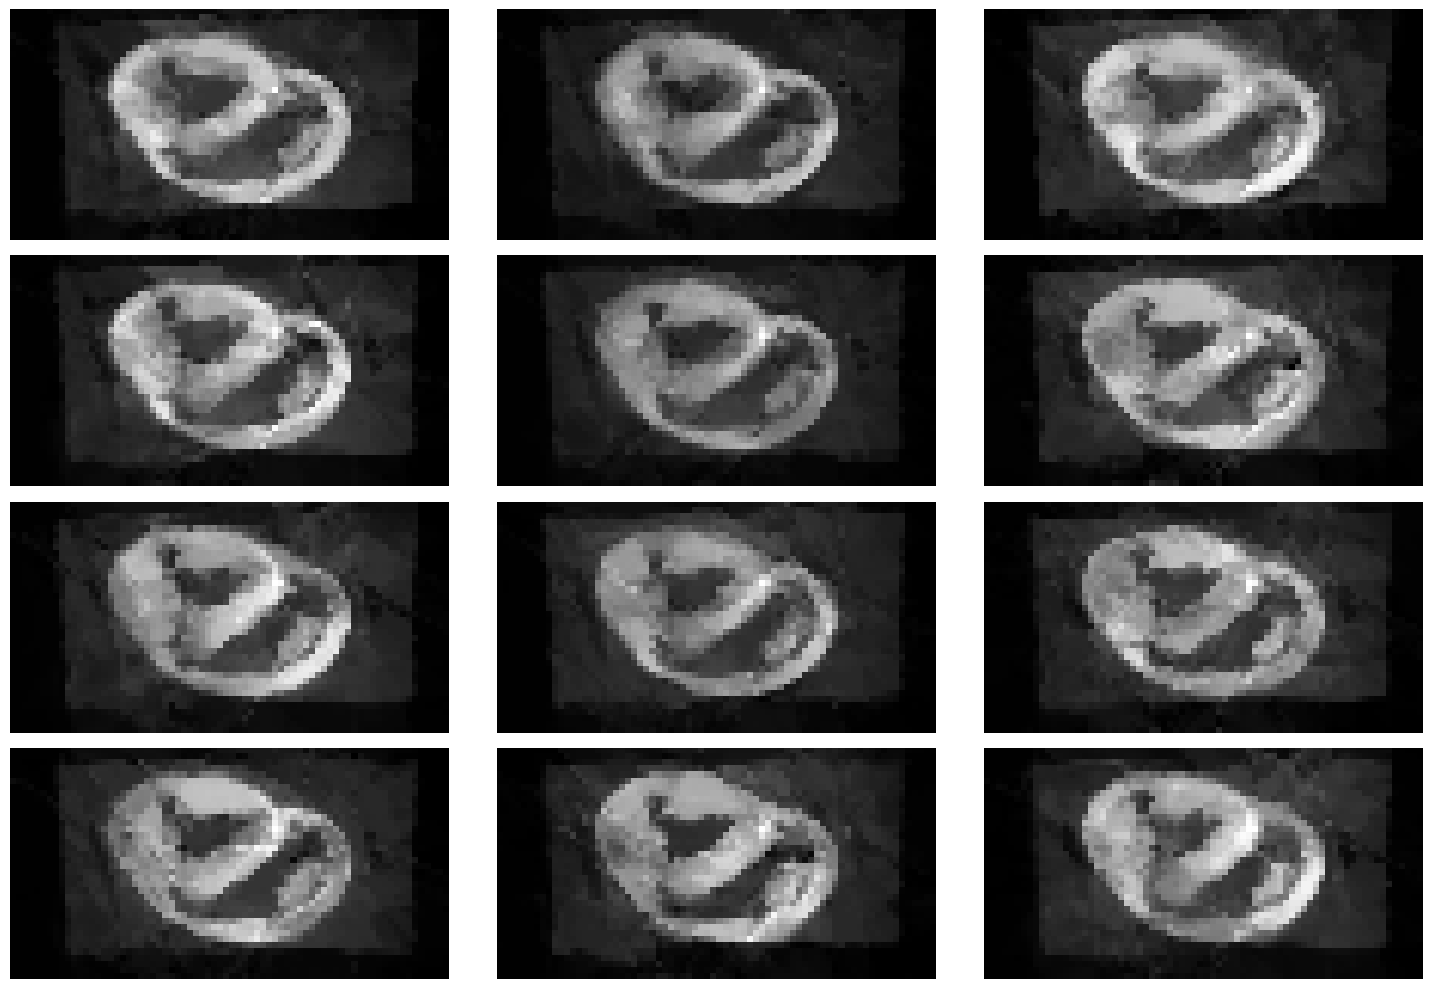

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_lr_exp200)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

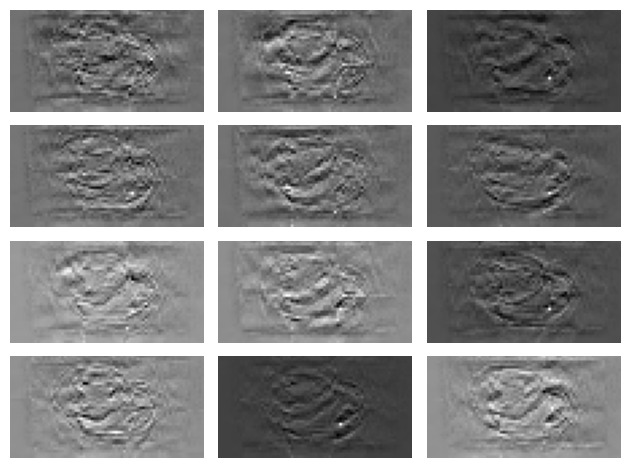

In [ ]:
# print(Nx, Ny)

for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_200mil)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()


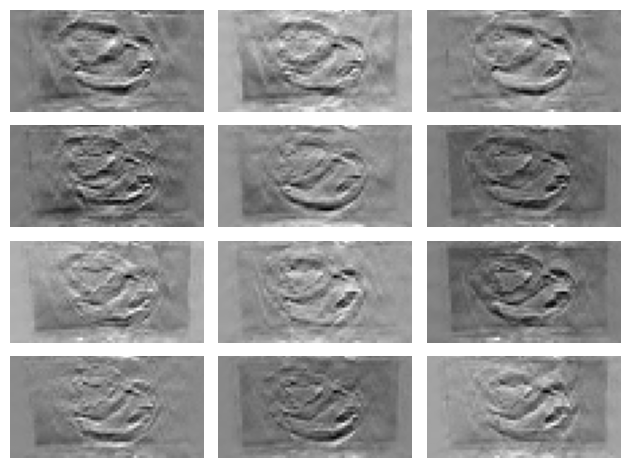

In [ ]:

for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_mae)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

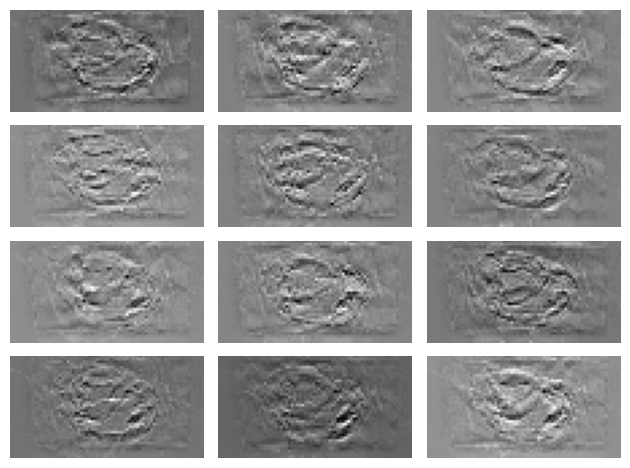

In [ ]:

for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_lr_exp200)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

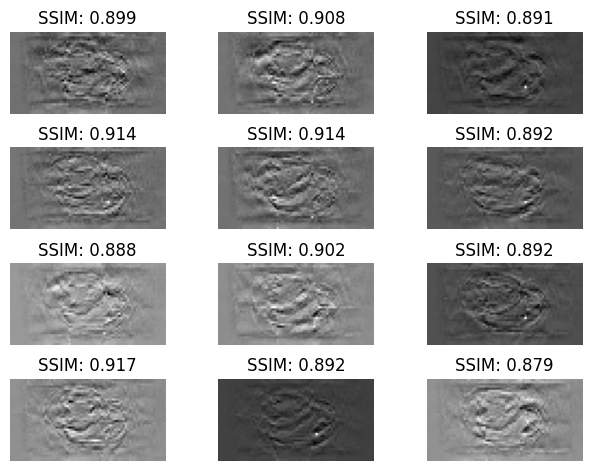

In [ ]:
from skimage.metrics import structural_similarity as ssim


for i, idx in enumerate(selected_dirs):
    plt.subplot(4, 3, i+1)

    inp = input[i]
    Img = ff_forwardpass(inp, params_200mil)
    Img = Img[:, 0] + 1j * Img[:, 1]
    I_img = np.abs(Img).reshape((Nx, Ny))

    gt_img = np.abs(slice[idx])
    img = gt_img  # ya tiene la forma correcta

    diff = I_img - img
    ssim_val = ssim(I_img, img, data_range=img.max() - img.min())

    plt.imshow(diff, cmap='gray')
    plt.title(f'SSIM: {ssim_val:.3f}')
    plt.axis('off')

plt.tight_layout()

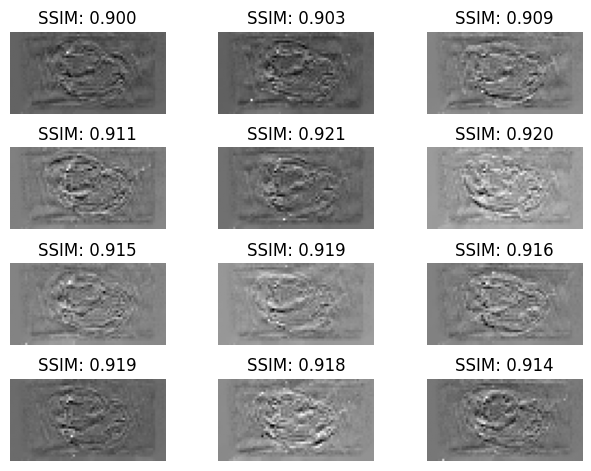

In [ ]:
from skimage.metrics import structural_similarity as ssim


for i, idx in enumerate(selected_dirs):
    plt.subplot(4, 3, i+1)

    inp = input[i]
    Img = ff_forwardpass(inp, params2)
    Img = Img[:, 0] + 1j * Img[:, 1]
    I_img = np.abs(Img).reshape((Nx, Ny))

    gt_img = np.abs(slice[idx])
    img = gt_img  # ya tiene la forma correcta

    diff = I_img - img
    ssim_val = ssim(I_img, img, data_range=img.max() - img.min())

    plt.imshow(diff, cmap='gray')
    plt.title(f'SSIM: {ssim_val:.3f}')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# !pip install piq


In [ ]:
# import torch
# from piq import fsim, ssim
# import numpy as np


# for i, idx in enumerate(selected_dirs):
#     plt.subplot(4, 3, i+1)

#     inp = input[i]
#     Img = ff_forwardpass(inp, params_200mil)
#     Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
#     I_img = np.abs(Img).reshape((Nx, Ny))
#     gt_img = np.abs(slice[idx])

#     # Normaliza entre 0 y 1
#     I_img = (I_img - I_img.min()) / (I_img.max() - I_img.min())
#     gt_img = (gt_img - gt_img.min()) / (gt_img.max() - gt_img.min())

#     I_tensor = torch.tensor(np.ascontiguousarray(I_img), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
#     gt_tensor = torch.tensor(gt_img.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)


#     # Calcula SSIM y FSIM
#     ssim_val = ssim(I_tensor, gt_tensor, data_range=1.0).item()
#     fsim_val = fsim(I_tensor, gt_tensor, data_range=1.0, chromatic=False).item()

#     # Dibuja diferencia + métricas
#     plt.imshow(I_img - gt_img, cmap='gray')
#     plt.title(f"SSIM: {ssim_val:.3f}\nFSIM: {fsim_val:.3f}")
#     plt.axis('off')

# plt.tight_layout()


In [ ]:
# import torch
# from piq import fsim, ssim
# import numpy as np


# for i, idx in enumerate(selected_dirs):
#     plt.subplot(4, 3, i+1)

#     inp = input[i]
#     Img = ff_forwardpass(inp, params_lr_exp200)
#     Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
#     I_img = np.abs(Img).reshape((Nx, Ny))
#     gt_img = np.abs(slice[idx])

#     # Normaliza entre 0 y 1
#     I_img = (I_img - I_img.min()) / (I_img.max() - I_img.min())
#     gt_img = (gt_img - gt_img.min()) / (gt_img.max() - gt_img.min())

#     I_tensor = torch.tensor(np.ascontiguousarray(I_img), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
#     gt_tensor = torch.tensor(gt_img.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)


#     # Calcula SSIM y FSIM
#     ssim_val = ssim(I_tensor, gt_tensor, data_range=1.0).item()
#     fsim_val = fsim(I_tensor, gt_tensor, data_range=1.0, chromatic=False).item()

#     # Dibuja diferencia + métricas
#     plt.imshow(I_img - gt_img, cmap='gray')
#     plt.title(f"SSIM: {ssim_val:.3f}\nFSIM: {fsim_val:.3f}")
#     plt.axis('off')

# plt.tight_layout()

In [ ]:
# import torch
# from piq import fsim, ssim
# import numpy as np


# for i, idx in enumerate(selected_dirs):
#     plt.subplot(4, 3, i+1)

#     inp = input[i]
#     Img = ff_forwardpass(inp, params2)
#     Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
#     I_img = np.abs(Img).reshape((Nx, Ny))
#     gt_img = np.abs(slice[idx])

#     # Normaliza entre 0 y 1
#     I_img = (I_img - I_img.min()) / (I_img.max() - I_img.min())
#     gt_img = (gt_img - gt_img.min()) / (gt_img.max() - gt_img.min())

#     I_tensor = torch.tensor(np.ascontiguousarray(I_img), dtype=torch.float32).unsqueeze(0).unsqueeze(0)
#     gt_tensor = torch.tensor(gt_img.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)


#     # Calcula SSIM y FSIM
#     ssim_val = ssim(I_tensor, gt_tensor, data_range=1.0).item()
#     fsim_val = fsim(I_tensor, gt_tensor, data_range=1.0, chromatic=False).item()

#     # Dibuja diferencia + métricas
#     plt.imshow(I_img - gt_img, cmap='gray')
#     plt.title(f"SSIM: {ssim_val:.3f}\nFSIM: {fsim_val:.3f}")
#     plt.axis('off')

# plt.tight_layout()

### Agregamos validación:

In [ ]:
# hacer un grupo de validación y entrenamiento:

from sklearn.model_selection import train_test_split
import jax.numpy as jnp

print(input.shape)
print(output.shape)

num_dirs = 12
vals_per_image = output.shape[0] // num_dirs
reconstructed_output = []

for i in range(12):
    img_vals = output[i * vals_per_image : (i + 1) * vals_per_image].reshape(-1)  # (792,)
    reconstructed_output.append(img_vals)

reconstructed_output = jnp.stack(reconstructed_output, axis=0)
print(reconstructed_output.shape)

train_input, val_input, train_output, val_output = train_test_split(
    input, reconstructed_output, test_size=0.2, random_state=42
)

train_output = train_output.reshape(-1)
val_output = val_output.reshape(-1)

print(train_input.shape, train_output.shape)
print(val_input.shape, val_output.shape)

(12, 2736, 4)
(32832,)
(12, 2736)
(9, 2736, 4) (24624,)
(3, 2736, 4) (8208,)


In [ ]:
# Agregamos un grupo de validación y early stopping

layers = [2*N_ff+2, 256, 256, 256, 2]
params = init_params(layers, key)
opt_state = opt_init(params)


masks_rep_train = np.concatenate((masks, masks[:3]), axis=0) # definimos una máscara para el entrenamiento
masks_rep_val = masks[:3] # definimos una máscara para la validación

def make_loss(mask_rep): # esta función loss es para poder usar las máscaras cuando se necesiten, en vez de usar un if, que no es compatible con jit
    @jit
    def loss(params, input, Y):
        k_spaces = vmap(partial(forward_model, params=params))(input)
        print(mask_rep.shape, k_spaces.shape, Y.shape)
        k_selected = k_spaces[mask_rep].reshape(-1)
        return jnp.mean(jnp.abs(k_selected - Y)**2 / n_pix)
    return loss


loss_train = make_loss(masks_rep_train)
loss_val = make_loss(masks_rep_val)


@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)  # extrae los parámetros
    g = grad(loss)(params, X_batch, Y_batch)  # calcula el gradiente de la función de pérdida respecto a los parámetros
    return opt_update(i, g, opt_state) # actualiza los parámetros con un tamaño adecuado


def train_val(loss, X, Y, valX, valY, opt_state, key,
              nIter=10000, patience=20, delta=1e-5):
    train_loss = []
    val_loss = []
    iterations = []

    wait = 0
    best_loss = float('inf')
    best_params = None

    for it in range(nIter):
        key, subkey = random.split(key)

        opt_state = step(loss_train, it, opt_state, X, Y)

        if it % 100 == 0:
            params = get_params(opt_state)

            train_loss_value = loss_train(params, X, Y)
            val_loss_value = loss_val(params, valX, valY)

            train_loss.append(train_loss_value)
            val_loss.append(val_loss_value)
            iterations.append(it)

            print(f"it {it}, train loss = {train_loss_value:.6e}, val loss = {val_loss_value:.6e}, wait = {wait}")

            # Early stopping
            if val_loss_value + delta < best_loss: # definimos una mejora, se tiene que superar por el loss del value
                best_loss = val_loss_value
                best_params = params
                wait = 0
            else:
                wait += 1 # va aumentando la cuenta, si llega a patience, se detiene.
            if wait >= patience:
                print(f"Early stopping at iteration {it}. Best val loss: {best_loss:.6e}")
                break

    return best_params, opt_state, train_loss, val_loss

# params_val, opt_state_val, train_loss, val_loss = train_val(loss_train, train_input, train_output, val_input, val_output, opt_state, key, nIter=100000, patience=2000, delta=1e-6

In [ ]:
# with open(f'{save_path}/params_val.pkl', 'wb') as f:
#     pickle.dump(params_val, f)

# with open(f'{save_path}/opt_state_val.pkl', 'wb') as f:
#     pickle.dump(opt_state_val, f)

In [ ]:
# with open(f'{save_path}/params_val.pkl', "rb") as f:
#     params_val = pickle.load(f)

# with open(f'{save_path}/opt_state_val.pkl', "rb") as f:
#     opt_state_val = pickle.load(f)

In [ ]:
# @jit
# def loss(params, input, Y):
#   k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
#   return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix

# loss(params_val, input, output)

In [ ]:
# plt.figure(figsize=(15,10))

# for i, inp in enumerate(input):
#     plt.subplot(4,3,i+1)
#     I = ff_forwardpass(inp, params_val)
#     I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
#     plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
#     plt.axis('off')

# plt.tight_layout()

In [ ]:
# hacemos droput de neuronas cada tanto


layers = [2*N_ff+2, 256, 256, 256, 2]
params = init_params(layers, key)
opt_state = opt_init(params)

# def forward_pass_dropout(x, params, key, train=True, dropout_rate=0.2):
#     keys = random.split(key, len(params))  # un key por capa
#     for i, (W, b) in enumerate(params[:-1]):
#         x = jnp.dot(x, W) + b
#         x = jax.nn.relu(x)
#         if train:
#             x = jax.nn.dropout(x, keys[i], rate=dropout_rate)
#     W_last, b_last = params[-1]
#     return jnp.dot(x, W_last) + b_last

# usar con train = False en testeo

# def loss_fn(params, input, y, key):
#     preds = forward_pass_dropout(input, params, key, train=True)
#     return jnp.mean((preds - y)**2)

### Cambio de sigma

In [ ]:
sigma = 1
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)

def train_early(loss, X, Y, opt_state, key, nIter = 10000, patience=2000, delta=1e-6):
    """
    Aquí entrenamos el modelo para varias iteraciones con batches de data X e Y que se crean aquí
    """
    train_loss = []
    val_loss = []

    wait = 0
    best_loss = float('inf')

    for it in range(nIter):
        key, subkey = random.split(key)
        # idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False) # toma un batch aleatorio
        opt_state = step(loss, it, opt_state, X, Y) # actualiza los parámetros con step
       # opt_state = step(loss, it, opt_state, X, Y)
        if it % 100 == 0:  # cada 100 iteraciones:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y) # train_loss_value = loss(params, X[idx_batch], Y[idx_batch])
            train_loss.append(train_loss_value)  # mide la pérdida del batch
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(f"it {it}, train loss = {train_loss_value:.6e}, wait = {wait}")


            # Early stopping
            if train_loss_value + delta < best_loss: # definimos una mejora, se tiene que superar por el loss del value
                best_loss = train_loss_value
                best_params = params
                wait = 0
            else:
                wait += 1 # va aumentando la cuenta, si llega a patience, se detiene.
            if wait >= patience:
                print(f"Early stopping at iteration {it}. Best val loss: {best_loss:.6e}")
                break

    return opt_state, train_loss, val_loss


# opt_state_sigma1, train_loss, val_loss = train_early(loss,input, output, opt_state, key, nIter= 100000, patience=2000, delta=1e-6) # sin early dropping

In [ ]:
# with open(f'{save_path}/params_sigma1.pkl', 'wb') as f:
#     pickle.dump(params_sigma1, f)

# with open(f'{save_path}/opt_state_sigma1.pkl', 'wb') as f:
#     pickle.dump(opt_state_sigma1, f)

In [ ]:
with open(f'{save_path}/params_sigma1.pkl', "rb") as f:
    params_sigma1 = pickle.load(f)

with open(f'{save_path}/opt_state_sigma1.pkl', "rb") as f:
    opt_state_sigma1 = pickle.load(f)

In [ ]:
params_sigma1 = get_params(opt_state_sigma1)
loss(params_sigma1, input, output)

Array(0.00016005, dtype=float32)

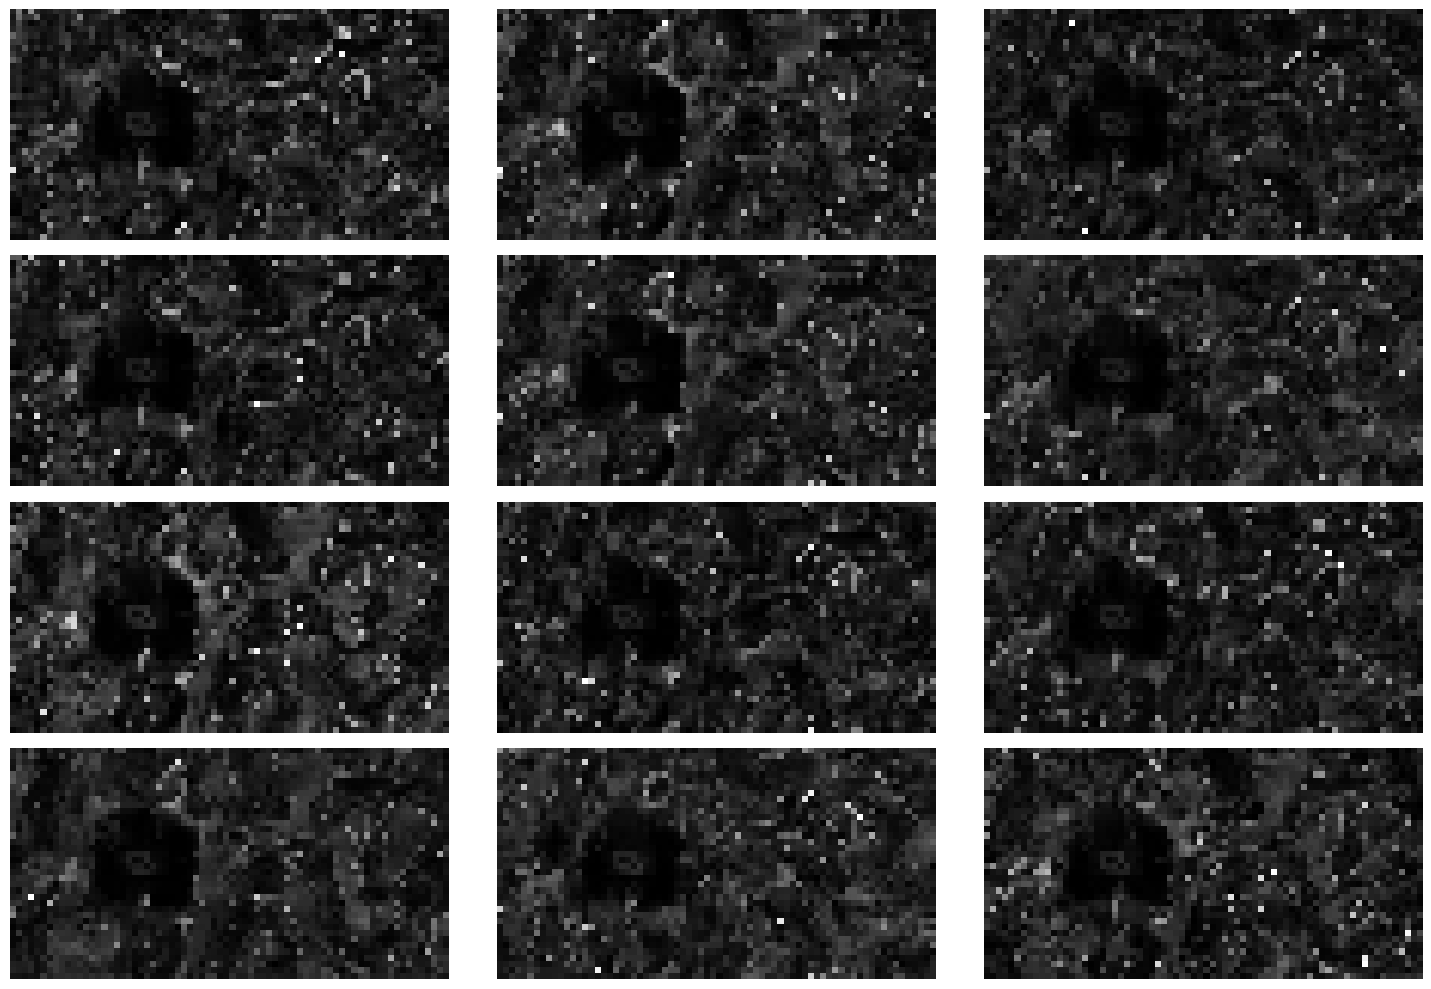

In [ ]:

plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_sigma1)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
print(psnr(params_sigma1, input, k_space[selected_dirs]))
print(loss_orig(params_sigma1, input, k_space[selected_dirs]))

(12, 38, 72)
78.451645
0.00016004975


In [ ]:
sigma = 0.5
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)


# opt_state_sigma2, train_loss, val_loss = train_early(loss,input, output, opt_state, key, nIter= 100000, patience=2000, delta=1e-6) # sin early dropping

In [ ]:
# with open(f'{save_path}/params_sigma2.pkl', 'wb') as f:
#     pickle.dump(params_sigma2, f)

# with open(f'{save_path}/opt_state_sigma2.pkl', 'wb') as f:
#     pickle.dump(opt_state_sigma2, f)

In [ ]:
with open(f'{save_path}/params_sigma2.pkl', "rb") as f:
    params_sigma2 = pickle.load(f)

with open(f'{save_path}/opt_state_sigma2.pkl', "rb") as f:
    opt_state_sigma2 = pickle.load(f)

In [ ]:
params_sigma2 = get_params(opt_state_sigma2)
loss(params_sigma2, input, output)

Array(0.00021181, dtype=float32)

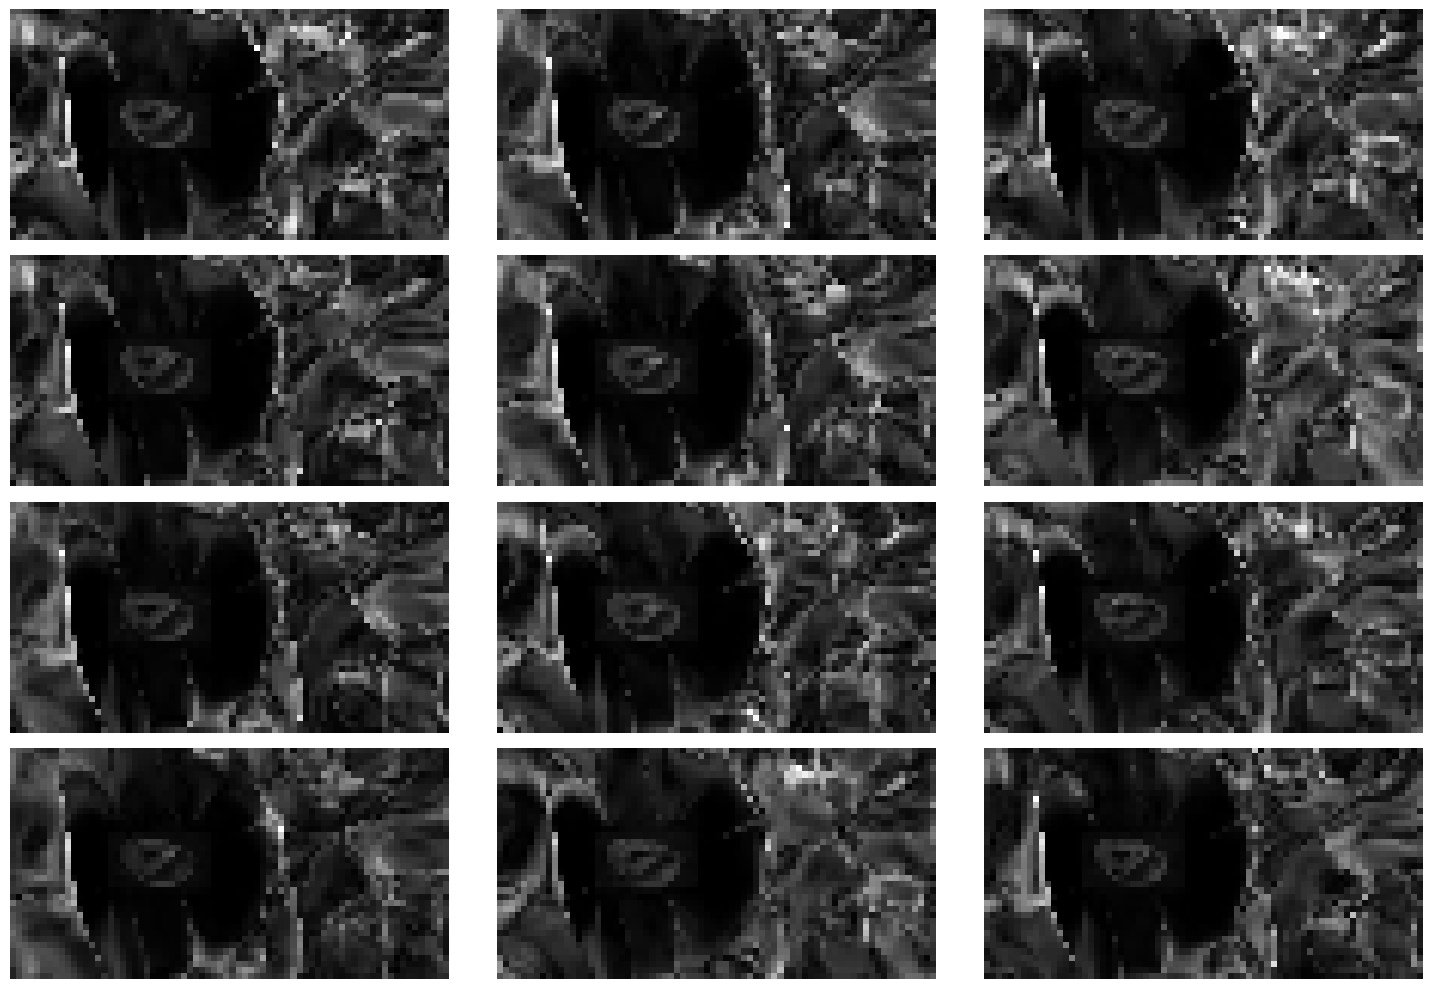

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_sigma2)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
print(loss(params_sigma2, input, output)) # mejora, tratar con más puntos
print(psnr(params_sigma2, input, k_space[selected_dirs]))
print(loss_orig(params_sigma2, input, k_space[selected_dirs]))

0.00021181053
(12, 38, 72)
77.23472
0.00021181053


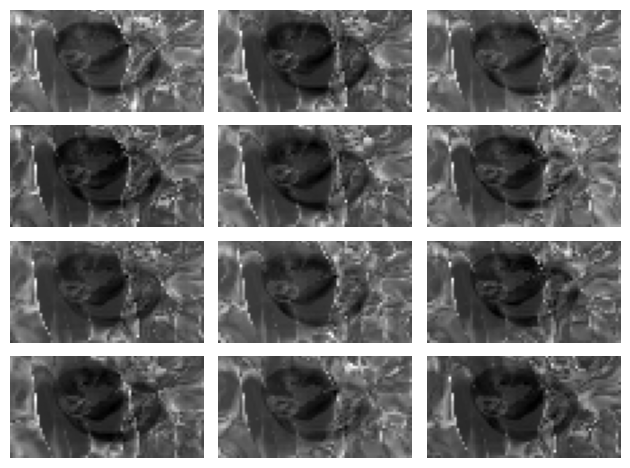

In [ ]:
for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_sigma2)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
sigma = 0.2
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)


# opt_state_sigma3, train_loss, val_loss = train_early(loss,input, output, opt_state, key, nIter= 100000, patience=2000, delta=1e-6) # sin early dropping

In [ ]:
with open(f'{save_path}/params_sigma3.pkl', "rb") as f:
    params_sigma3 = pickle.load(f)

with open(f'{save_path}/opt_state_sigma3.pkl', "rb") as f:
    opt_state_sigma3 = pickle.load(f)

In [ ]:
params_sigma3 = get_params(opt_state_sigma3)
loss(params_sigma3, input, output)

Array(0.00019522, dtype=float32)

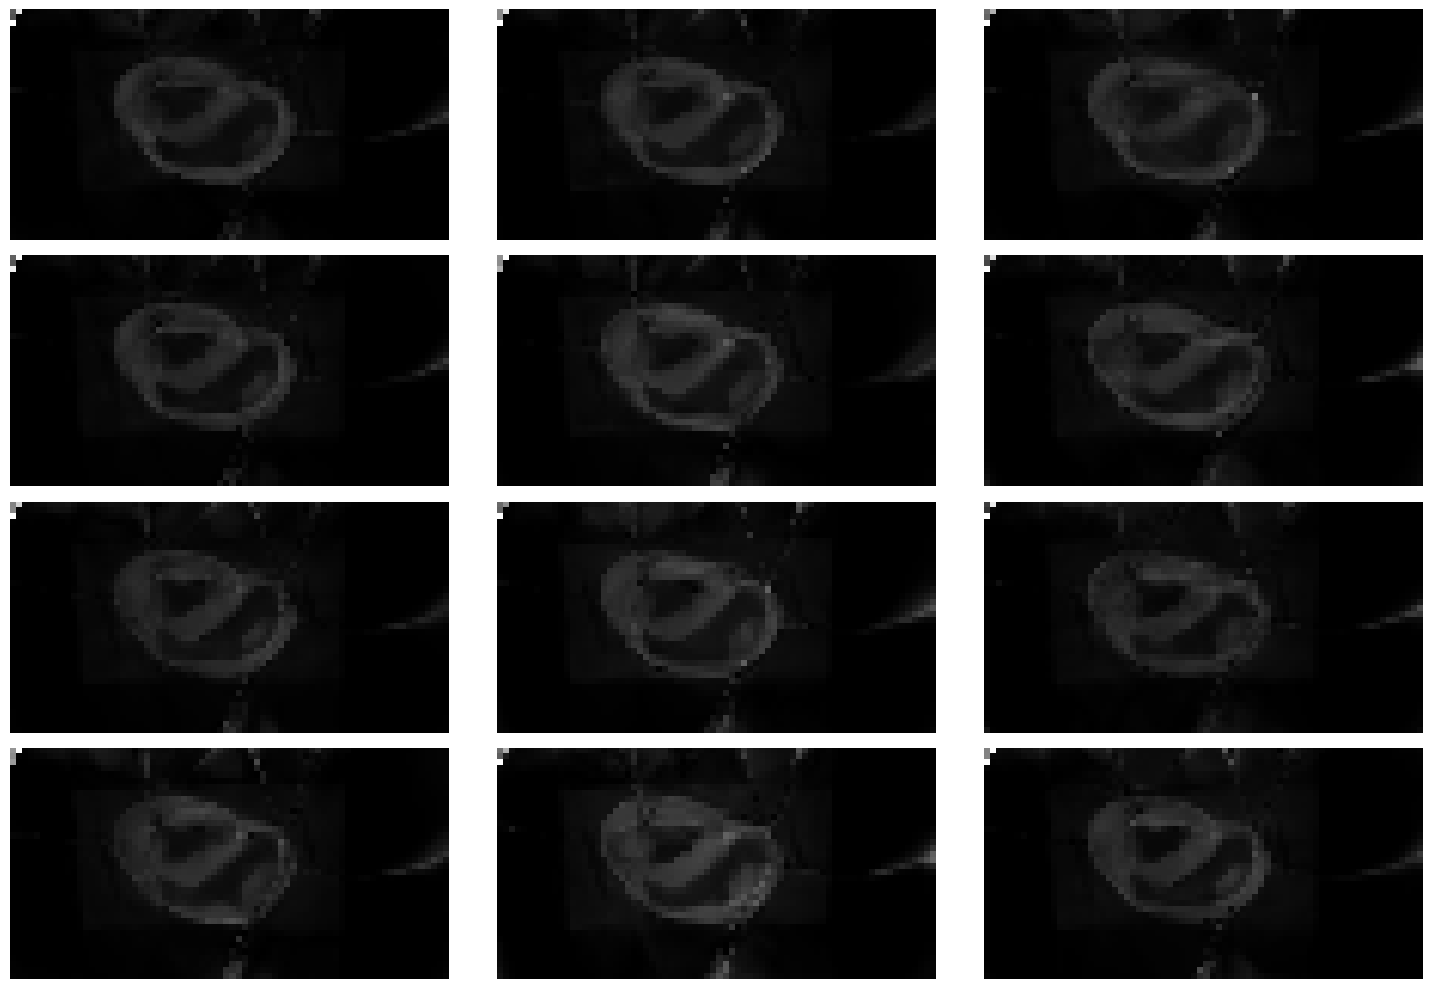

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_sigma3)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

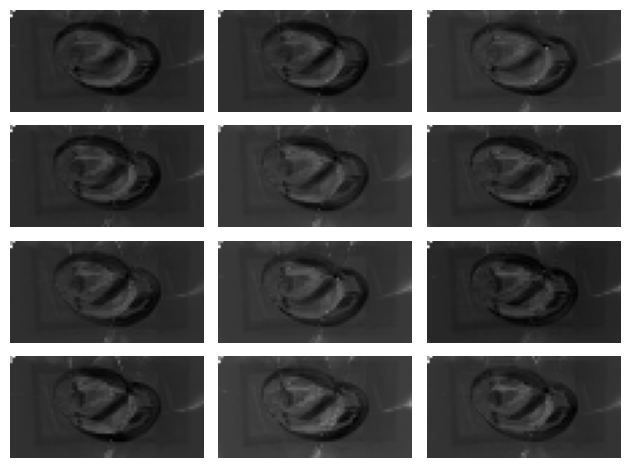

In [ ]:
for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_sigma3)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I_img.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
sigma = 0.17
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)


# opt_state_sigma4, train_loss, val_loss = train_early(loss,input, output, opt_state, key, nIter= 100000, patience=2000, delta=1e-6) # sin early dropping

In [ ]:
with open(f'{save_path}/params_sigma4.pkl', "rb") as f:
    params_sigma4 = pickle.load(f)

with open(f'{save_path}/opt_state_sigma4.pkl', "rb") as f:
    opt_state_sigma4 = pickle.load(f)

In [ ]:
params_sigma4 = get_params(opt_state_sigma4)
loss(params_sigma4, input, output)

Array(0.00019522, dtype=float32)

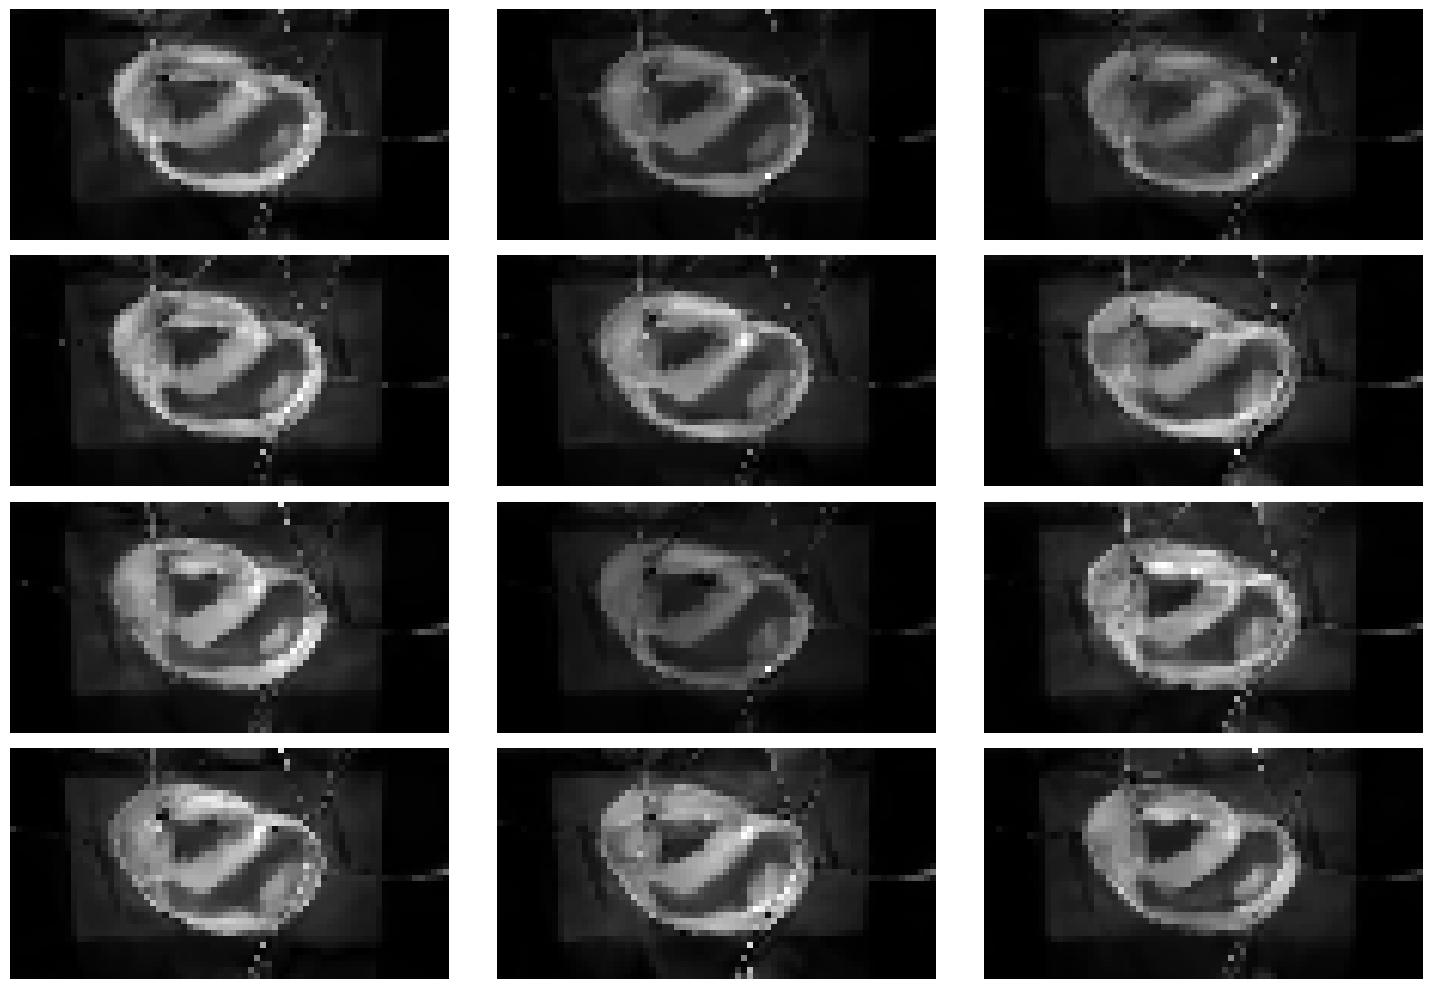

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_sigma4)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

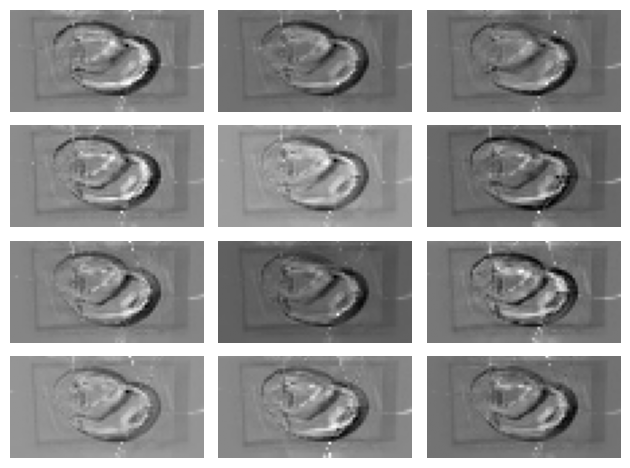

In [ ]:
for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_sigma4)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I_img.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# opt_state_sigma4k, train_loss, val_loss = train_early(loss,input, output, opt_state, key, nIter= 200000, patience=400, delta=1e-6) # sin early dropping

In [ ]:
# with open(f'{save_path}/params_sigma4k.pkl', 'wb') as f:
#     pickle.dump(params_sigma4k, f)

# with open(f'{save_path}/opt_state_sigma4k.pkl', 'wb') as f:
#     pickle.dump(opt_state_sigma4k, f)

with open(f'{save_path}/params_sigma4k.pkl', "rb") as f:
    params_sigma4k = pickle.load(f)

with open(f'{save_path}/opt_state_sigma4k.pkl', "rb") as f:
    opt_state_sigma4k = pickle.load(f)

In [ ]:
params_sigma4k = get_params(opt_state_sigma4k)
loss(params_sigma4k, input, output)

Array(0.00037518, dtype=float32)

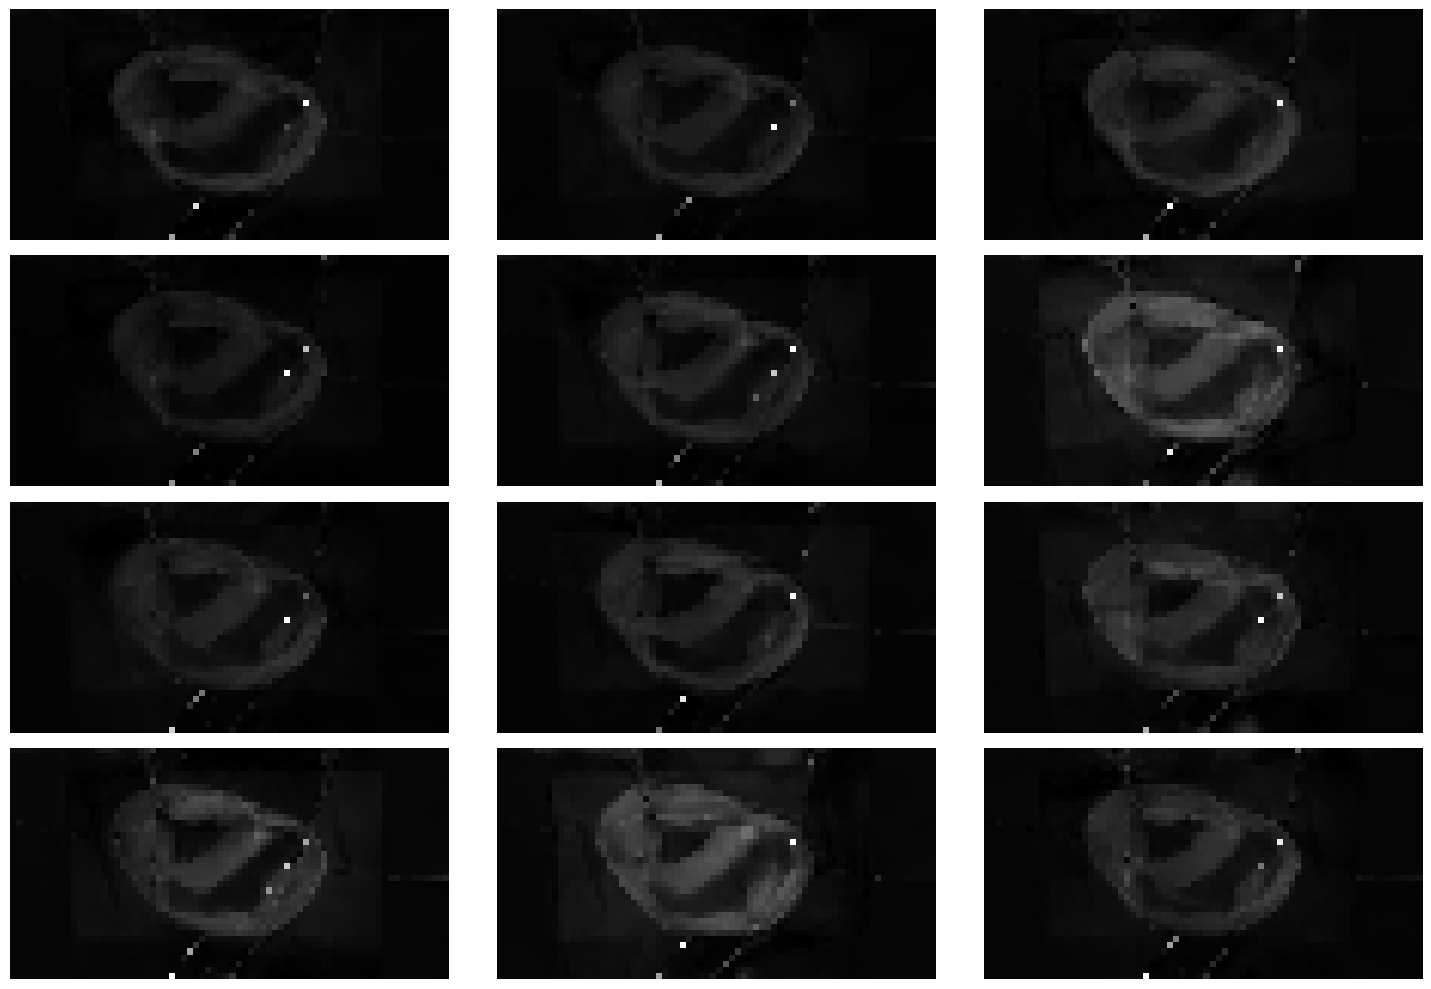

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_sigma4k)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
print(loss(params_sigma4k, input, output)) # mejora, tratar con más puntos
print(psnr(params_sigma4k, input, k_space[selected_dirs]))
print(loss_orig(params_sigma4k, input, k_space[selected_dirs]))

0.00037517893
(12, 38, 72)
74.751816
0.00037517893


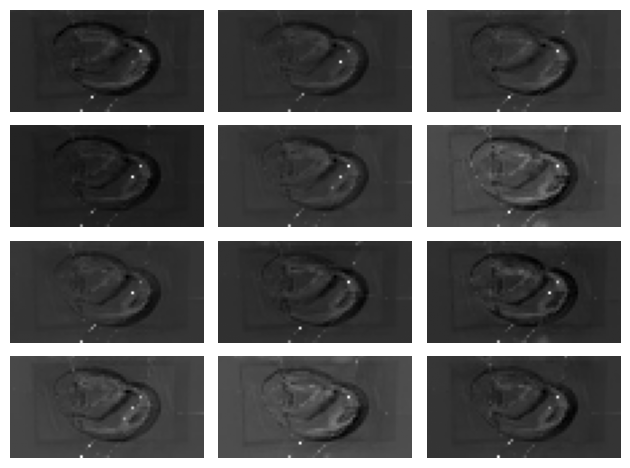

In [ ]:
for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_sigma4k)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I_img.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
opt_state_mil, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 60000) # 60000

it 0, train loss = 6.326863e+00
it 100, train loss = 2.254152e-03
it 200, train loss = 1.978113e-03
it 300, train loss = 1.889607e-03
it 400, train loss = 1.840002e-03
it 500, train loss = 1.800352e-03
it 600, train loss = 1.759298e-03
it 700, train loss = 1.708333e-03
it 800, train loss = 1.637551e-03
it 900, train loss = 1.778151e-03
it 1000, train loss = 1.478324e-03
it 1100, train loss = 1.374446e-03
it 1200, train loss = 1.296131e-03
it 1300, train loss = 1.230114e-03
it 1400, train loss = 1.166363e-03
it 1500, train loss = 1.100588e-03
it 1600, train loss = 1.052050e-03
it 1700, train loss = 9.613556e-04
it 1800, train loss = 8.817753e-04
it 1900, train loss = 8.202335e-04
it 2000, train loss = 7.786542e-04
it 2100, train loss = 1.136010e-03
it 2200, train loss = 7.350517e-04
it 2300, train loss = 7.147443e-04
it 2400, train loss = 6.894837e-04
it 2500, train loss = 6.675671e-04
it 2600, train loss = 6.744507e-04
it 2700, train loss = 6.364726e-04
it 2800, train loss = 9.746946e-

In [ ]:
params_mil = get_params(opt_state_mil)
loss(params_mil, input, output)

Array(6.530451e-05, dtype=float32)

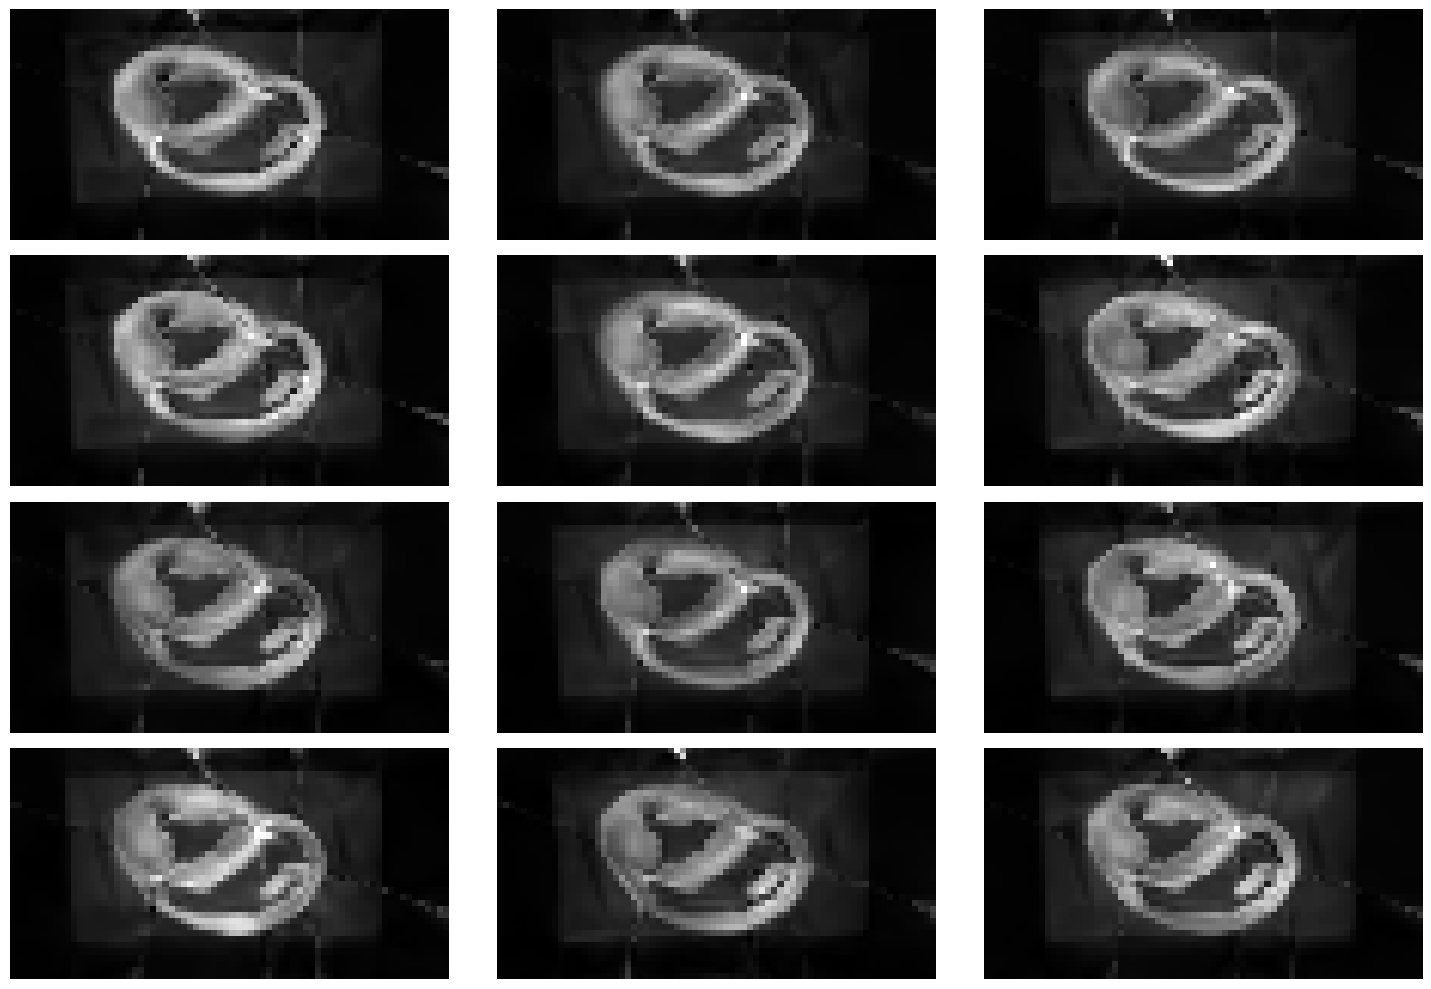

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_mil)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
opt_state_cienmil_todo, train_loss, val_loss = train(loss,input, output, opt_state_mil, key, nIter= 40000) # 100000

it 0, train loss = 6.189439e-05
it 100, train loss = 4.131078e-05
it 200, train loss = 3.107680e-05
it 300, train loss = 2.547122e-05
it 400, train loss = 2.229286e-05
it 500, train loss = 2.027154e-05
it 600, train loss = 1.885432e-05
it 700, train loss = 1.780870e-05
it 800, train loss = 1.700491e-05
it 900, train loss = 1.635607e-05
it 1000, train loss = 1.597601e-05
it 1100, train loss = 1.541055e-05
it 1200, train loss = 1.827776e-05
it 1300, train loss = 1.515242e-05
it 1400, train loss = 1.443557e-05
it 1500, train loss = 1.111216e-04
it 1600, train loss = 1.400239e-05
it 1700, train loss = 5.885091e-05
it 1800, train loss = 1.629782e-05
it 1900, train loss = 1.947036e-05
it 2000, train loss = 5.636278e-05
it 2100, train loss = 1.857710e-05
it 2200, train loss = 4.055215e-05
it 2300, train loss = 1.687812e-05
it 2400, train loss = 1.370849e-05
it 2500, train loss = 5.386815e-05
it 2600, train loss = 1.858215e-05
it 2700, train loss = 2.880899e-05
it 2800, train loss = 8.759683e-

In [ ]:
params_cienmil_todo = get_params(opt_state_cienmil_todo)
loss(params_cienmil_todo, input, output)

Array(6.7147994e-06, dtype=float32)

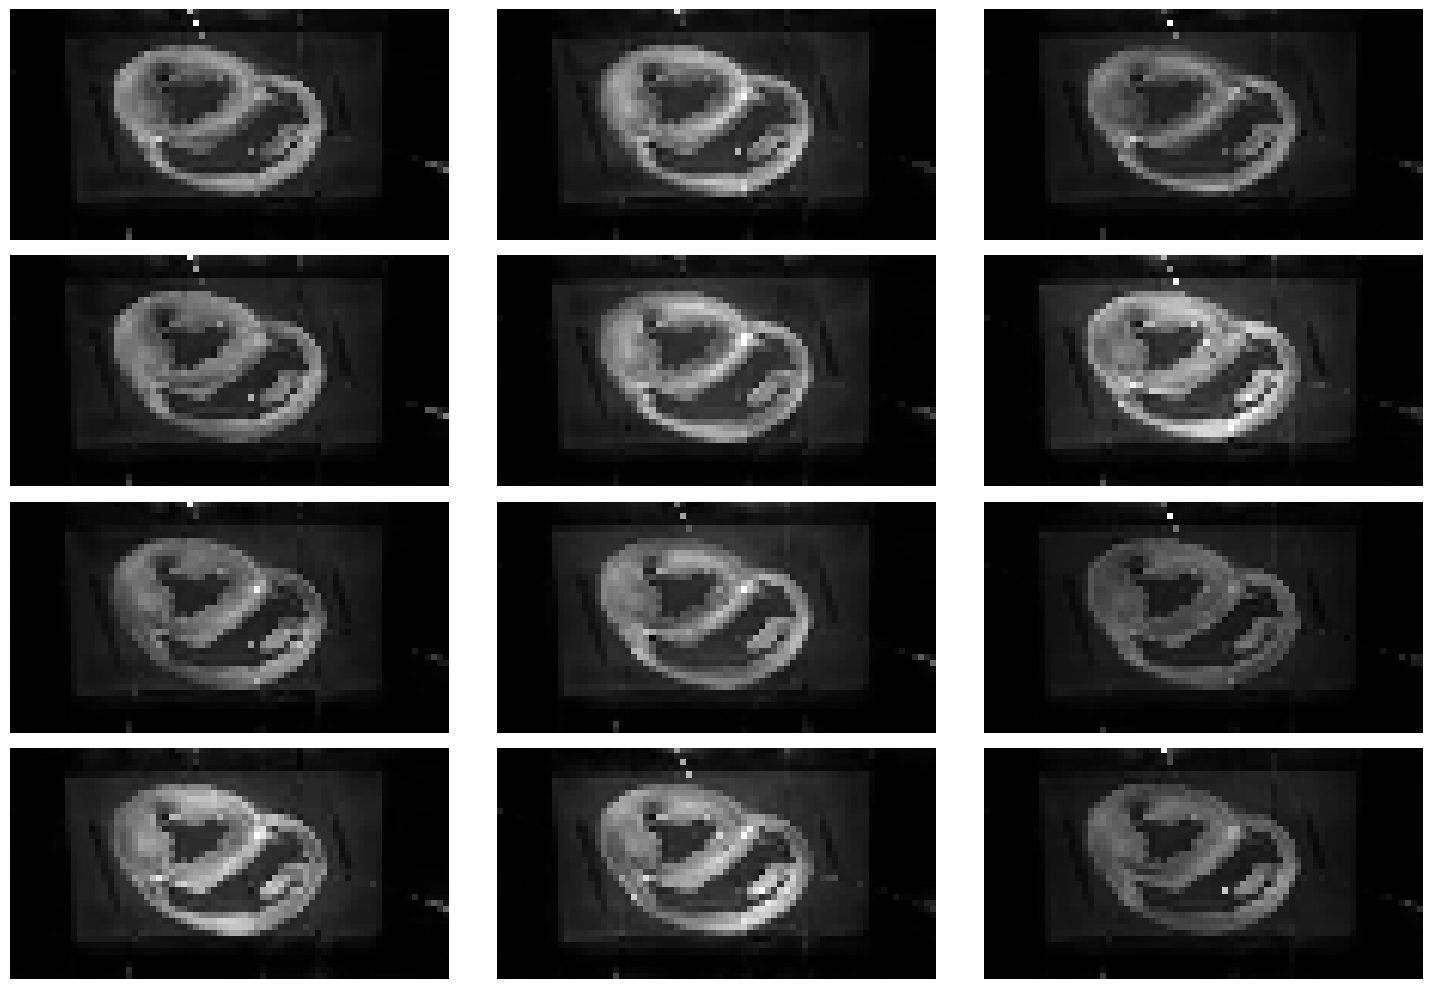

In [ ]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_cienmil_todo)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
# with open(f'{save_path}/params_cienmil_todo.pkl', 'wb') as f:
#     pickle.dump(params_cienmil_todo, f)

# with open(f'{save_path}/opt_state_cienmil_todo.pkl', 'wb') as f:
#     pickle.dump(opt_state_cienmil_todo, f)

with open(f'{save_path}/params_cienmil_todo.pkl', "rb") as f:
    params_cienmil_todo = pickle.load(f)

with open(f'{save_path}/opt_state_cienmil_todo.pkl', "rb") as f:
    opt_state_cienmil_todo = pickle.load(f)

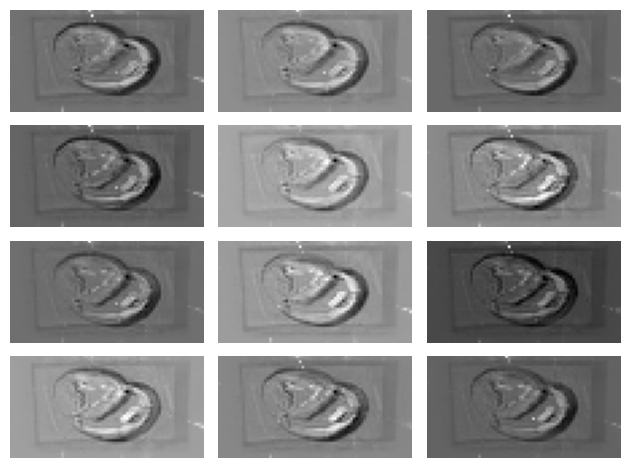

In [ ]:
for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_cienmil_todo)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I_img.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()